# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

## Context
![image.png](output/images/vcd-task.png)

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

![image-3.png](output/images/vcd-graph.png)

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the stimulus frames
- the ROI masks for each cell
- a maximum activity projection of the recorded area
- running speed
- table of stimulus epochs

You will only work with a locally sparse noise stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [1]:
# import packages here

import numpy as np
import pandas as pd
import jupyter_black

jupyter_black.load()

# Load project data

In [2]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_rf.npz", allow_pickle=True)
    data = dict(data)
    array2df(data, "stim_table", ["frame", "start", "end"])
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 3)
[stim] - <class 'numpy.ndarray'>, - (9000, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



In [3]:
import utils as U
import importlib

importlib.reload(
    U
)  # Reload utils to ensure you're using the latest version of your functions

/home/andi/anaconda3/envs/calcium-env/lib/python3.11/site-packages/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


<module 'utils' from '/home/andi/Documents/nds-final-project-summer25/utils.py'>

# 0 Data exploration
In this first section we explore the data that was given to us.

# Duration of the experiment

The $t$ vector gives the time in seconds for each recorded point of the experiment. From this we can deduce that the current sampling rate is approximately `30.14` Hz and the number of frames we have gathered data for is `105968`. The estimated sampling rate from these recorded times is approximately.

In [4]:
print(data["t"])
# Deduced Sampling rate.
sampling_intervals = np.diff(data["t"])
sampling_rate = 1 / np.mean(sampling_intervals)
print(f"Estimated sampling rate: {sampling_rate:.2f} Hz")

[   9.33015    9.36332    9.39649 ... 3524.51876 3524.55193 3524.5851 ]
Estimated sampling rate: 30.14 Hz


### Plot preprocessed Activity Traces
We are given the already preprocessed activity rates as `df/f` for each of the $189$ nuerons give us $105968$ measrued activity from the calcium imaging recordings. We plot it for a random neuron.

(189, 105968)


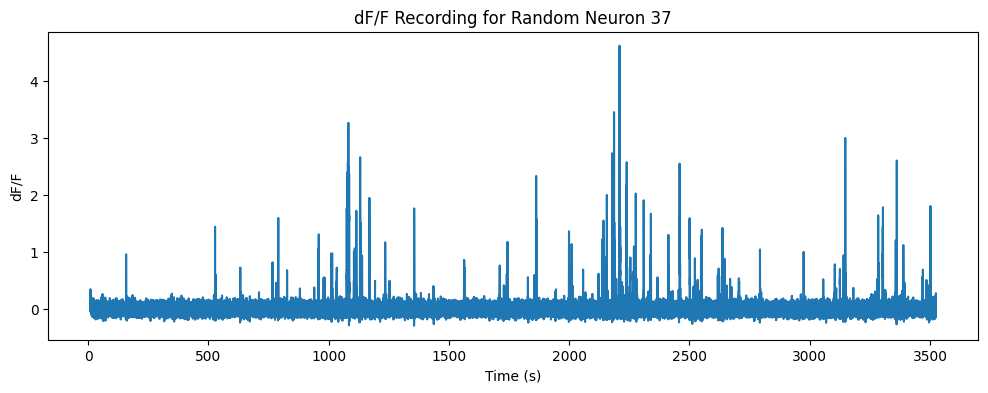

In [5]:
import numpy as np

import matplotlib.pyplot as plt

print(data["dff"].shape)

# Select a random neuron index
num_neurons = data["dff"].shape[0]
random_neuron_idx = np.random.randint(num_neurons)

# Plot the dff recording for the selected neuron
plt.figure(figsize=(12, 4))
plt.plot(data["t"], data["dff"][random_neuron_idx])
plt.title(f"dF/F Recording for Random Neuron {random_neuron_idx}")
plt.xlabel("Time (s)")
plt.ylabel("dF/F")
plt.show()

## Stimulus Meta-Data



# Stimulus

The stimulus consists of 9000 unique frames each of size $16 \times 28$ of gray scale values. The stimulus is defined as `locally_sparse_stimlus` and is active for certain subset of of the trial.

Shape of stimulus data (9000, 16, 28)


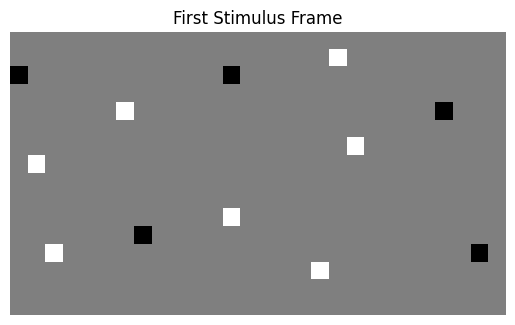

Number of unique stimulus frames: 9000


In [ ]:
import matplotlib.pyplot as plt

print(f"Shape of stimulus data {data['stim'].shape}")

plt.imshow(data["stim"][0], cmap="gray")
plt.title("First Stimulus Frame")
plt.axis("off")
plt.show()
# Check uniqueness of stimulus frames
num_unique_frames = np.unique(
    data["stim"].reshape(data["stim"].shape[0], -1), axis=0
).shape[0]
print(f"Number of unique stimulus frames: {num_unique_frames}")
assert num_unique_frames == data["stim"].shape[0], "Not all stimulus frames are unique!"
# Confirm that each stimulus frame is unique, we were not sure about that 

We save all of the stimuli in pictures. Currently this gets skipped because save_all_images_to_directory = False

In [ ]:
import os
import matplotlib.pyplot as plt

save_all_images_to_directory = True
output_dir = "."
if save_all_images_to_directory:
    stim_frames = data["stim"]
    n_frames = stim_frames.shape[0]
    frames_per_page = 25
    n_pages = int(np.ceil(n_frames / frames_per_page))

    # Ensure output directory exists
    stim_grid_dir = os.path.join(output_dir, "stimulus_grids")
    os.makedirs(stim_grid_dir, exist_ok=True)

    for page in range(n_pages):
        fig, axes = plt.subplots(5, 5, figsize=(10, 10))
        axes = axes.flatten()
        start_idx = page * frames_per_page
        end_idx = min(start_idx + frames_per_page, n_frames)
        for i, ax in enumerate(axes):
            frame_idx = start_idx + i
            if frame_idx < end_idx:
                ax.imshow(stim_frames[frame_idx], cmap="gray")
                ax.set_title(f"Frame {frame_idx}")
            ax.axis("off")
        plt.tight_layout()
        filename = os.path.join(stim_grid_dir, f"stimulus_grid_page_{page+1}.png")
        plt.savefig(filename)
        plt.close(fig)
else:
    print(
        "Skipping saving all images to directory. Set `save_all_images_to_directory` to True to enable saving."
    )

Fitting neurons: 0it [16:43, ?it/s]


### What are locally sparse noise stimulus ?

**Locally Sparse**: In each frame, most of the screen is a neutral grey. Only a few, small, randomly 
chosen locations ("local") have either a black or a white square. The rest of the screen is blank ("sparse").

## What is th frequency with which a particular stimulus frame is held ?

The `data['stim_table']` contains 8880 rows indicating the stimulus frame which is shown and duration  in both sample indices and the start and end time in seconds. Each of the 8880 rows contain one frame after the other all the way from $[0 -  8879]$ inclusive

In [8]:
print(f"Stim Table shape: {data['stim_table'].shape}")
data["stim_table"]

Stim Table shape: (8880, 3)


frame   start     end
0         0     737     744
1         1     745     752
2         2     752     759
3         3     760     767
4         4     767     774
...     ...     ...     ...
8875   8875  105705  105712
8876   8876  105712  105719
8877   8877  105720  105727
8878   8878  105727  105734
8879   8879  105735  105742

[8880 rows x 3 columns]

In [9]:
# Check that the frame in tim table is not repeated
# Check that the frame in stim_table is not repeated
num_unique_frames_in_table = data["stim_table"]["frame"].nunique()
num_total_frames_in_table = len(data["stim_table"]["frame"])
print(f"Unique frames in stim_table: {num_unique_frames_in_table}")
print(f"Total frames in stim_table: {num_total_frames_in_table}")
if num_unique_frames_in_table == num_total_frames_in_table:
    print("No repeated frames in stim_table.")
else:
    print("There are repeated frames in stim_table.")

Unique frames in stim_table: 8880
Total frames in stim_table: 8880
No repeated frames in stim_table.


In [10]:
# Che3ck that data["stim"] each row contains distinct unique frames.
# Check that each row in data["stim"] is unique
stim_reshaped = data["stim"].reshape(data["stim"].shape[0], -1)
num_unique_stim_frames = np.unique(stim_reshaped, axis=0).shape[0]
print(f"Number of unique frames in data['stim']: {num_unique_stim_frames}")
assert (
    num_unique_stim_frames == data["stim"].shape[0]
), "Not all frames in data['stim'] are unique!"

Number of unique frames in data['stim']: 9000


In [11]:
# The total number of samples by looking and the number of sample in each row  by takding difference of start and end sample points and adding them up gives
total_samples = np.sum(data["stim_table"]["end"] - data["stim_table"]["start"])
print(f"Total number of samples in the stimulus table: {total_samples}")

Total number of samples in the stimulus table: 62521


### Are all the frames in the stim table one ofter the other, that is incrementing by one on each row or not ?


In [12]:
# Check if 'frame' column increments by one for each row
frame_diffs = data["stim_table"]["frame"].diff().fillna(1)
all_consecutive = np.all(frame_diffs == 1)
print(f"Are all frames consecutive? {all_consecutive}")

# If not, show indices where it's not consecutive
if not all_consecutive:
    non_consecutive_indices = np.where(frame_diffs != 1)[0]
    print(f"Indices where frames are not consecutive: {non_consecutive_indices}")
    print(
        f"Frame values at those indices: {data['stim_table']['frame'].iloc[non_consecutive_indices].values}"
    )

Are all frames consecutive? True


 #### Are there any un accounted for gaps between start and end in the data['stim_table'], that is does the, start of one row proceed right after the end of the previous row?

In [13]:
import numpy as np

stim_table = data["stim_table"]
gaps = stim_table["start"].values[1:] - stim_table["end"].values[:-1]
print(f"Number of gaps found: {np.sum(gaps > 0)}")
if np.any(gaps > 0):
    print("There are gaps between start and end in the data['stim_table'].")
    print(f"Number of gaps found: {np.sum(gaps > 0)}")
    print(f"Indices of gaps found: {np.where(gaps > 0)[0]}")
    # what is the size of the gaps?
    gap_sizes = gaps[gaps > 0]
    print(f"Sizes of gaps found: {gap_sizes}")
    print(f"Start of gaps: {stim_table['start'].values[1:][gaps > 0]}")
    print(f"End of gaps: {stim_table['end'].values[:-1][gaps > 0]}")
    # what is the maximum gap size ?
    max_gap_size = np.max(gap_sizes)
    print(f"Maximum gap size: {max_gap_size}")
    # what is the minimum gap size ?
    min_gap_size = np.min(gap_sizes)
    print(f"Minimum gap size: {min_gap_size}")
    # what is the average gap size ?
    avg_gap_size = np.mean(gap_sizes)
    print(f"Average gap size: {avg_gap_size}")
    # what is the median gap size ?
    median_gap_size = np.median(gap_sizes)
    print(f"Median gap size: {median_gap_size}")
else:
    print("No gaps found between start and end in the data['stim_table'].")

Number of gaps found: 4462
There are gaps between start and end in the data['stim_table'].
Number of gaps found: 4462
Indices of gaps found: [   0    2    4 ... 8874 8876 8878]
Sizes of gaps found: [1 1 1 ... 1 1 1]
Start of gaps: [   745    760    775 ... 105705 105720 105735]
End of gaps: [   744    759    774 ... 105704 105719 105734]
Maximum gap size: 19015
Minimum gap size: 1
Average gap size: 9.521290900941281
Median gap size: 1.0


### Stimulus Epoch Table

The stimulus epoch table consists tells us the durations where locally_sparse_noise is active.

In [14]:
data["stim_epoch_table"]

start    end stimulus
0  locally_sparse_noise    737    22461
1           spontaneous  22611    31520
2     natural_movie_one  31521    40571
3  locally_sparse_noise  41476    63199
4     natural_movie_two  64105    73156
5           spontaneous  73306    82207
6  locally_sparse_noise  82208   105742

In [15]:
data.keys()

dict_keys(['t', 'dff', 'stim_table', 'stim', 'roi_masks', 'max_projection', 'running_speed', 'stim_epoch_table'])

# Mouse running Speed  Data

The element `data['running_speed']` contains information regarding the running speed of the mouse, it has 
the shape $2 \times 105968$ where `data['running_speed'][1]` consists of the running speed at points of time. The mouse running 
speed/behavioral data is not used in our current analysis.

In [16]:
data["running_speed"][1].shape

(105968,)

# What is the maximal activity projection?


The "Maximum Activity Projection" is a single summary image created by collapsing that entire movie into one picture.

For every single pixel in the 512x512 grid, the computer looks through all the frames of the movie and finds the highest (maximum) brightness value that pixel ever reached during the entire recording. It then creates a new, single image where each pixel's value is set to that maximum brightness.

The resulting image gives you a static, anatomical-like view of the recording area.

* **Bright Spots**: The brightest spots in the projection are typically the locations of neurons (or parts of neurons) that were highly active (i.e., had a large calcium influx, causing high fluorescence) at some point during the experiment.

* **Background**: The dimmer areas are parts of the tissue that were never highly fluorescent.

Why is it useful ?

It serves as an excellent anatomical reference map. It's the perfect background image to overlay  other spatial data on, such as:

The ROI masks to see the exact outlines of the detected neurons.

The receptive field centers, show where the "seeing" parts of the neurons are located relative to their physical bodies.

# ROI Masks
## What are ROI masks ?


ROI masks indicate the position and rough planar geometry of the nueron. Only ROI centers not their morphology is used in present analysis.

In [17]:
roi_masks = data["roi_masks"]
roi_masks.shape

(189, 512, 512)

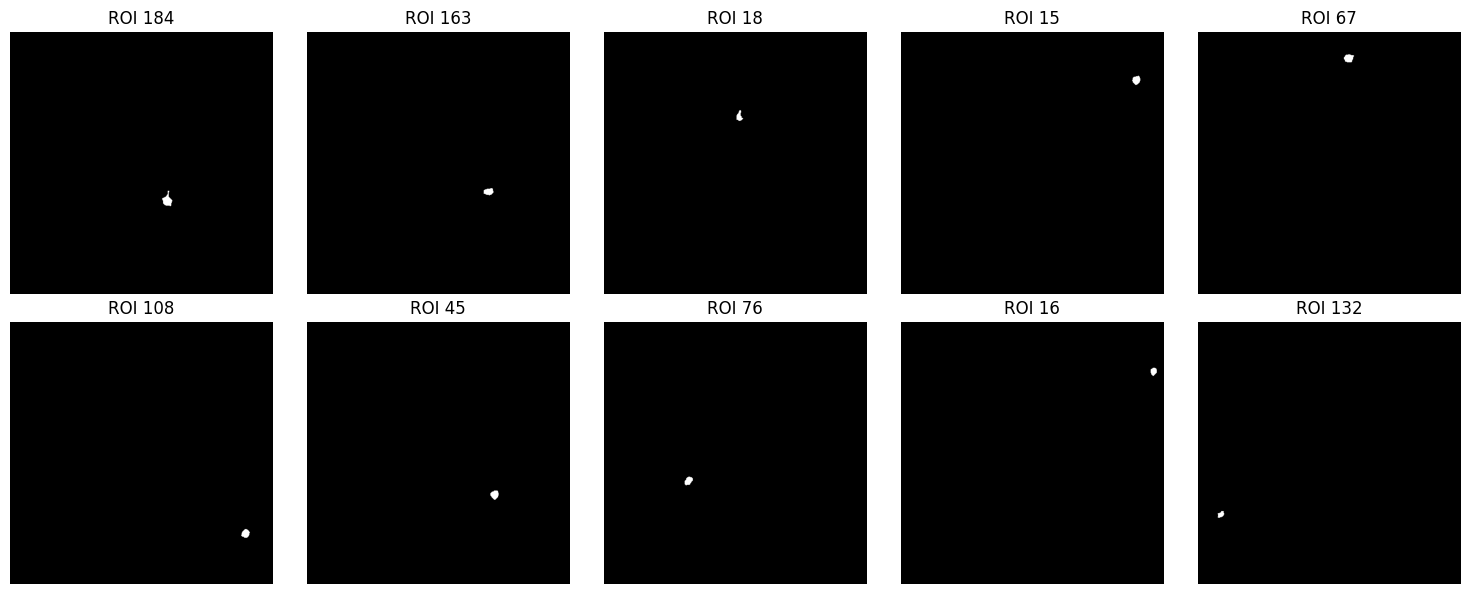

In [18]:
# Plot 10 random roi masks.
np.random.seed(42)
random_indices = np.random.choice(roi_masks.shape[0], size=10, replace=False)
roi_masks_to_plot = roi_masks[random_indices]

# plot
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(roi_masks_to_plot[i], cmap="gray")
    ax.set_title(f"ROI {random_indices[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Save Processed Dataset

In [19]:
# import packages here
import numpy as np
import pandas as pd
import jupyter_black

jupyter_black.load()

# File paths
paths = {
    "dff": "dff_data_rf/dff.npy",
    "t": "dff_data_rf/t.npy",
    "stim": "dff_data_rf/stim.npy",
    "stim_table": "dff_data_rf/stim_table.npy",
    "stim_epoch_table": "dff_data_rf/stim_epoch_table.npy",
    "roi_masks": "dff_data_rf/roi_masks.npy",
    "max_projection": "dff_data_rf/max_projection.npy",
    "running_speed": "dff_data_rf/running_speed.npy",
}

In [20]:
import utils as ae
import importlib

importlib.reload(
    ae
)  # Reload ae_utils to ensure you're using the latest version of your functions

data = ae.load_data(paths)

print("dff:", data["dff"].shape)
print("t:", data["t"].shape)
print("stim:", data["stim"].shape)
print("stim_table:", data["stim_table"].shape)
print("stim_epoch_table:", data["stim_epoch_table"].shape)
print("First stim_epoch_table row:", data["stim_epoch_table"][0])

dff: (189, 105968)
t: (105968,)
stim: (9000, 16, 28)
stim_table: (8880, 3)
stim_epoch_table: (7, 3)
First stim_epoch_table row: ['locally_sparse_noise' 737 22461]


In [21]:
import utils as ae

# import isolate_sparse_epochs, compute_qc_metrics


mask = ae.isolate_sparse_epochs(data, target="locally_sparse_noise")
dff_sparse = data["dff"][:, mask]
t_sparse = data["t"][mask]
print(f"Sparse‑noise frames: {mask.sum()}")

var_raw, snr_raw = ae.compute_qc_metrics(dff_sparse)

data.update(
    {
        "mask_sparse": mask,
        "dff_sparse": dff_sparse,
        "t_sparse": t_sparse,
        "var_raw": var_raw,
        "snr_raw": snr_raw,
    }
)

Sparse‑noise frames: 66981


## 1.4 Repair & Store Running Speed

In [22]:
rs = data["running_speed"]  # shape: (2, T)
n_nans = [np.isnan(r).sum() for r in rs]
print(f"NaNs in running_speed rows: {n_nans}")

# pick the row with fewer NaNs as time
if n_nans[0] < n_nans[1]:
    run_t, run_speed = rs
else:
    run_speed, run_t = rs

run_speed = np.nan_to_num(run_speed, nan=0.0)

data.update(
    {
        "run_t": run_t,
        "run_speed": run_speed,
    }
)

print("run_t[:5]:    ", run_t[:5])
print("run_speed[:5]:", run_speed[:5])

NaNs in running_speed rows: [np.int64(299), np.int64(0)]
run_t[:5]:     [9.33015 9.36332 9.39649 9.42967 9.46284]
run_speed[:5]: [0. 0. 0. 0. 0.]


## 1.5 Flag “Good” vs. “Bad” Cells for Plotting

In [23]:
var_thr_raw = np.percentile(var_raw, 10)
snr_thr_raw = np.percentile(snr_raw, 10)
all_cells = np.arange(data["dff"].shape[0])
good_cells = np.where((var_raw > var_thr_raw) & (snr_raw > snr_thr_raw))[0]
bad_cells = np.setdiff1d(all_cells, good_cells)

print(f"Kept {len(good_cells)}/{len(all_cells)} cells after raw QC")

data.update(
    {
        "var_thr_raw": var_thr_raw,
        "snr_thr_raw": snr_thr_raw,
        "good_cells": good_cells,
        "bad_cells": bad_cells,
    }
)

Kept 151/189 cells after raw QC


## 1.6 Plotting

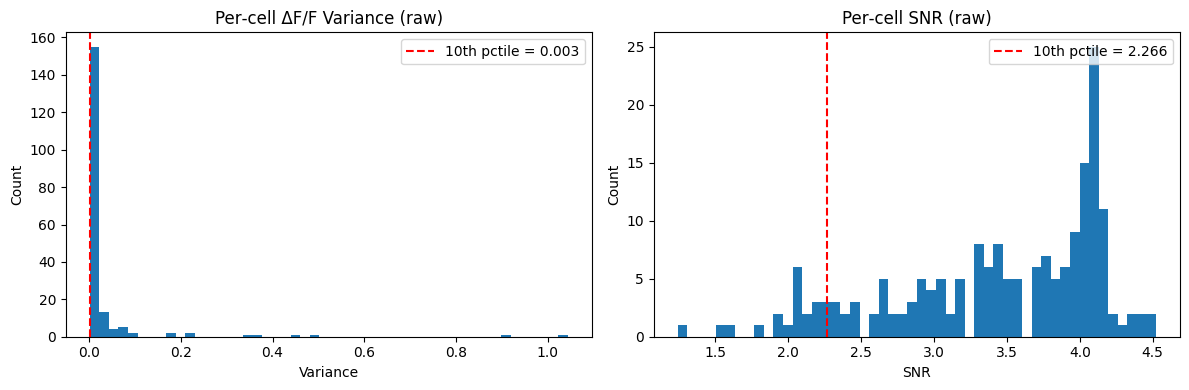

In [24]:
# QC — Raw ΔF/F Variance & SNR Distributions
import matplotlib.pyplot as plt

# recompute 10th‑percentile thresholds on the raw metrics
var_thr_raw = np.percentile(data["var_raw"], 10)
snr_thr_raw = np.percentile(data["snr_raw"], 10)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Variance (raw)
axs[0].hist(data["var_raw"], bins=50)
axs[0].axvline(
    var_thr_raw, color="r", linestyle="--", label=f"10th pctile = {var_thr_raw:.3f}"
)
axs[0].set_title("Per‑cell ΔF/F Variance (raw)")
axs[0].set_xlabel("Variance")
axs[0].set_ylabel("Count")
axs[0].legend()

# SNR (raw)
axs[1].hist(data["snr_raw"], bins=50)
axs[1].axvline(
    snr_thr_raw, color="r", linestyle="--", label=f"10th pctile = {snr_thr_raw:.3f}"
)
axs[1].set_title("Per‑cell SNR (raw)")
axs[1].set_xlabel("SNR")
axs[1].set_ylabel("Count")
axs[1].legend()

plt.tight_layout()
plt.show()

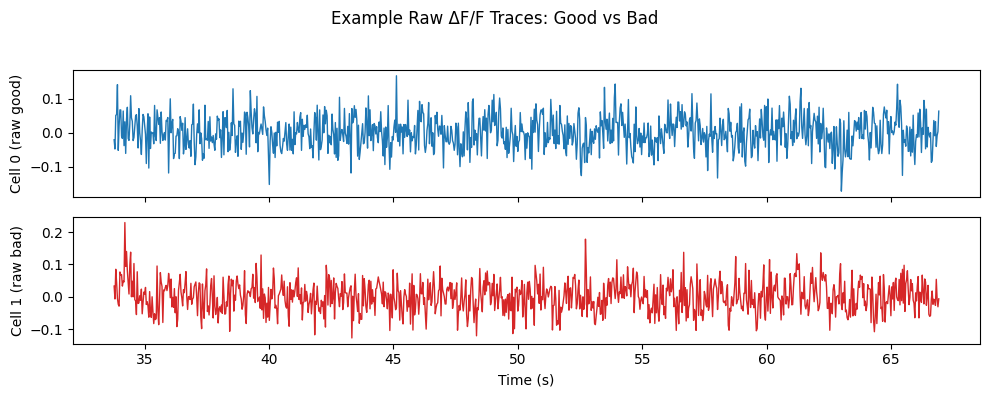

In [25]:
# QC — Example Raw ΔF/F Traces: “Good” vs. “Bad” (pre‑clean)

# recompute thresholds in case this cell is run independently
var_thr_raw = np.percentile(data["var_raw"], 10)
snr_thr_raw = np.percentile(data["snr_raw"], 10)

n_cells = data["dff"].shape[0]
raw_good = np.where((data["var_raw"] > var_thr_raw) & (data["snr_raw"] > snr_thr_raw))[
    0
]
raw_bad = np.setdiff1d(np.arange(n_cells), raw_good)

# pick one example of each
cg, cb = raw_good[0], raw_bad[0]

fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
ax[0].plot(data["t_sparse"][:1000], data["dff_sparse"][cg, :1000], lw=1)
ax[0].set_ylabel(f"Cell {cg} (raw good)")
ax[1].plot(data["t_sparse"][:1000], data["dff_sparse"][cb, :1000], lw=1, color="C3")
ax[1].set_ylabel(f"Cell {cb} (raw bad)")
ax[1].set_xlabel("Time (s)")
plt.suptitle("Example Raw ΔF/F Traces: Good vs Bad")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [26]:
# QC: fraction of session that is sparse-noise
frac = data["mask_sparse"].mean()
print(f"Fraction of session in sparse-noise epochs: {frac:.3f} ({frac*100:.1f}%)")

Fraction of session in sparse-noise epochs: 0.632 (63.2%)


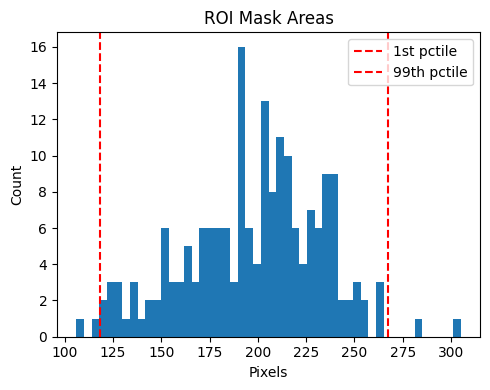

In [27]:
# QC — ROI‑Mask Area Distribution
areas = np.array([mask.sum() for mask in data["roi_masks"]])
p1 = np.percentile(areas, 1)
p99 = np.percentile(areas, 99)

plt.figure(figsize=(5, 4))
plt.hist(areas, bins=50)
plt.axvline(p1, color="r", linestyle="--", label="1st pctile")
plt.axvline(p99, color="r", linestyle="--", label="99th pctile")
plt.title("ROI Mask Areas")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

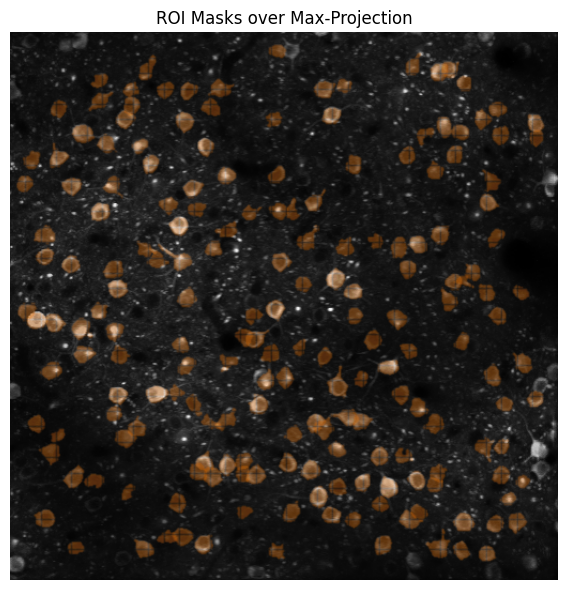

In [28]:
# QC — Overlay All ROI Masks on Max‑Projection
plt.figure(figsize=(6, 6))
plt.imshow(data["max_projection"], cmap="gray")
for i in range(data["roi_masks"].shape[0]):
    ys, xs = np.nonzero(data["roi_masks"][i])
    plt.scatter(xs, ys, s=1, alpha=0.05, color="C1")
plt.title("ROI Masks over Max‑Projection")
plt.axis("off")
plt.tight_layout()
plt.show()

In [29]:
# QC — Unique Epoch Names
epochs = data["stim_epoch_table"]
first = epochs[0]
name_col = next(i for i, x in enumerate(first) if isinstance(x, str))
names = epochs[:, name_col].astype(str)

print("Unique epoch names:\n", np.unique(names))

Unique epoch names:
 ['locally_sparse_noise' 'natural_movie_one' 'natural_movie_two'
 'spontaneous']


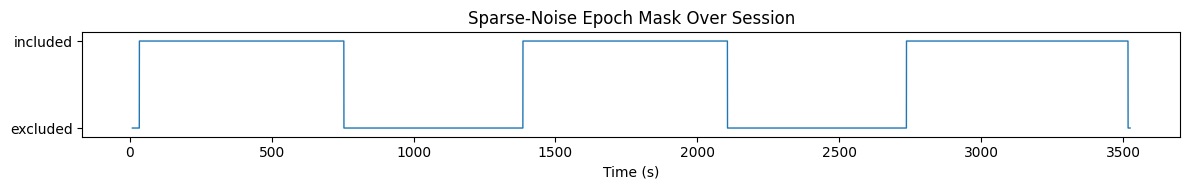

In [30]:
# QC — Sparse‑Noise Epoch Mask Timeline
plt.figure(figsize=(12, 2))
plt.plot(data["t"], data["mask_sparse"], lw=1)
plt.ylim(-0.1, 1.1)
plt.yticks([0, 1], ["excluded", "included"])
plt.xlabel("Time (s)")
plt.title("Sparse‑Noise Epoch Mask Over Session")
plt.tight_layout()
plt.show()

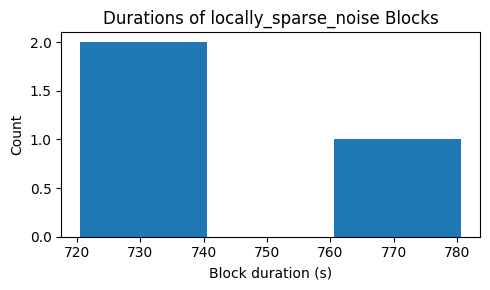

Mean block duration: 740.6s, n blocks = 3


In [31]:
# QC — Durations of locally_sparse_noise Blocks
idx = np.where(np.diff(data["mask_sparse"].astype(int)) != 0)[0] + 1
starts = idx[0::2]
ends = idx[1::2]
dts = np.median(np.diff(data["t"]))
durs = (ends - starts) * dts

plt.figure(figsize=(5, 3))
plt.hist(durs, bins=len(durs))
plt.xlabel("Block duration (s)")
plt.ylabel("Count")
plt.title("Durations of locally_sparse_noise Blocks")
plt.tight_layout()
plt.show()

print(f"Mean block duration: {durs.mean():.1f}s, n blocks = {len(durs)}")

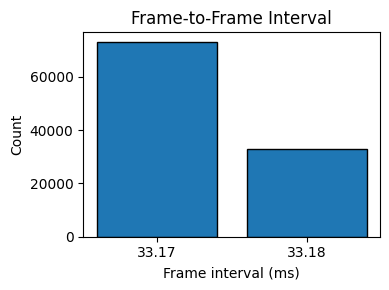

Frame intervals:
  33.17 ms → 73011 frames
  33.18 ms → 32956 frames
Median = 33.170 ms


In [32]:
# QC — Frame‑to‑Frame Interval Distribution (ms)
import numpy as np
import matplotlib.pyplot as plt

# 1) compute intervals in ms and round to two decimals
dts_ms = np.round(np.diff(data["t"]) * 1e3, 2)

# 2) get the two unique values and their counts
uni, counts = np.unique(dts_ms, return_counts=True)

# 3) bar‑plot with a small width so they sit side by side
fig, ax = plt.subplots(figsize=(4, 3))
bar_width = (uni[1] - uni[0]) * 0.8  # 80% of the gap
ax.bar(uni, counts, width=bar_width, edgecolor="k", color="C0")

# 4) tidy up axes
ax.set_xticks(uni)
ax.set_xticklabels([f"{u:.2f}" for u in uni])
ax.set_xlabel("Frame interval (ms)")
ax.set_ylabel("Count")
ax.set_title("Frame‑to‑Frame Interval")

plt.tight_layout()
plt.show()

# 5) print a concise summary
print(
    f"Frame intervals:\n"
    f"  {uni[0]:.2f} ms → {counts[0]} frames\n"
    f"  {uni[1]:.2f} ms → {counts[1]} frames\n"
    f"Median = {np.median(dts_ms):.3f} ms"
)

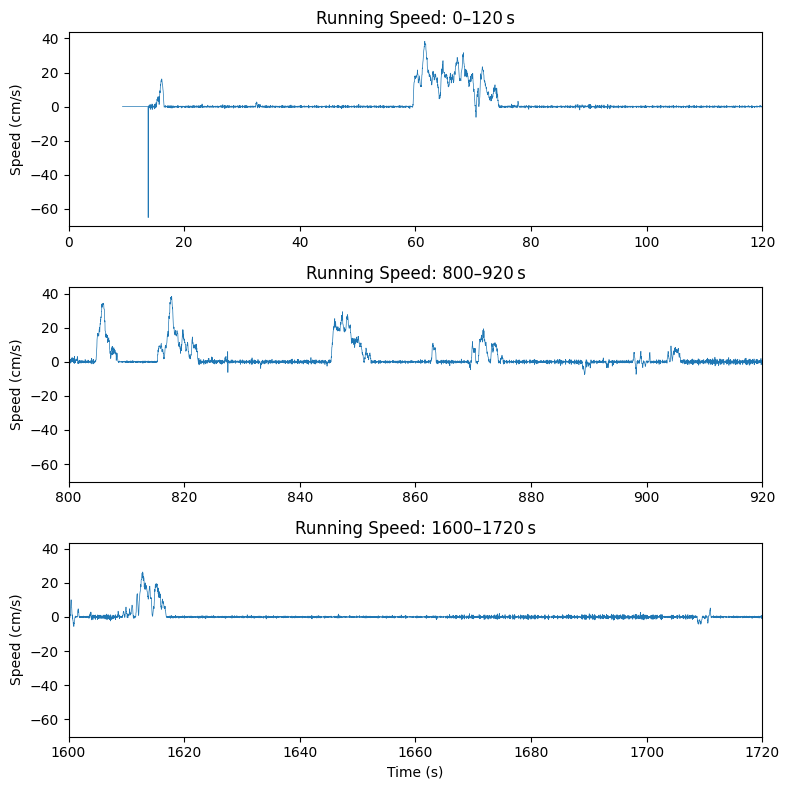

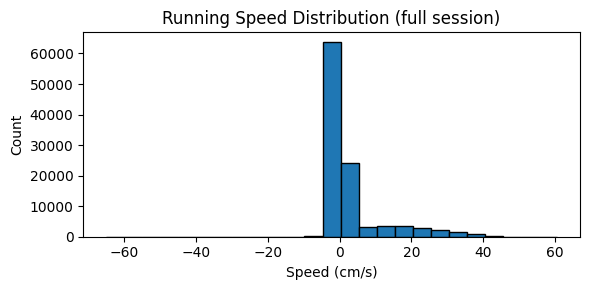

Speed stats — min: -65.1 cm/s, max: 60.6 cm/s, median: 0.1 cm/s


In [33]:
# QC — Running Speed Snippets Across Session

# retrieve cleaned time & speed
run_t = data["run_t"]
run_speed = data["run_speed"]

# define three 2‑minute windows (in seconds)
windows = [0, 800, 1600]

fig, axs = plt.subplots(len(windows), 1, figsize=(8, 8), sharey=True)

for ax, start in zip(axs, windows):
    # mask for 120‑s snippet
    mask = (run_t >= start) & (run_t < start + 120)
    ax.plot(run_t[mask], run_speed[mask], lw=0.5)
    ax.set_xlim(start, start + 120)
    ax.set_ylabel("Speed (cm/s)")
    ax.set_title(f"Running Speed: {start}–{start+120} s")

# label only the bottom axis
axs[-1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

# 3) histogram of full‐session speed
plt.figure(figsize=(6, 3))
plt.hist(run_speed, bins=25, edgecolor="k")
plt.xlabel("Speed (cm/s)")
plt.ylabel("Count")
plt.title("Running Speed Distribution (full session)")
plt.tight_layout()
plt.show()

# 4) concise printed stats
print(
    f"Speed stats — min: {run_speed.min():.1f} cm/s, "
    f"max: {run_speed.max():.1f} cm/s, "
    f"median: {np.median(run_speed):.1f} cm/s"
)

In [34]:
import numpy as np
import pandas as pd


def get_clean_stim_mapping(stim_table, t_full, mask_sparse, n_stim):
    """
    Builds a full‐length and sparse clean mapping from time to stimulus index,
    filling any gaps so that there are no -1s or out-of-range values.

    Args:
        stim_table (np.ndarray or pd.DataFrame): columns [frame, start, end] or [stim_idx, onset, duration].
        t_full (np.ndarray): full time vector (length = total timesteps).
        mask_sparse (np.ndarray of bool): mask of sparse‐selected timesteps.
        n_stim (int): number of stimulus frames.

    Returns:
        stim_id_full_clean (np.ndarray[int], shape=(len(t_full),)):
            Cleaned stimulus index at every timestep, no -1 or out of range.
        stim_id_clean (np.ndarray[int], shape=(mask_sparse.sum(),)):
            Subset for sparse‐selected timesteps.
    """
    # --- Step 1: build raw full‐length map using original function ---
    # It expects columns ['frame','start','end']
    active = np.full(len(t_full), -1, dtype=int)
    if isinstance(stim_table, np.ndarray):
        rows = [tuple(r) for r in stim_table]
    else:
        rows = stim_table[["frame", "start", "end"]].itertuples(index=False, name=None)
    for frame_id, start_idx, end_idx in rows:
        fid = int(frame_id)
        s = max(int(start_idx), 0)
        e = min(int(end_idx), len(t_full))
        if s < e:
            active[s:e] = fid
    stim_id_full = active

    # --- Step 2: mask invalid entries (−1 or ≥ n_stim) ---
    invalid = (stim_id_full < 0) | (stim_id_full >= n_stim)

    # --- Step 3: convert to float and mark invalid as NaN ---
    fm = stim_id_full.astype(float)
    fm[invalid] = np.nan

    # --- Step 4: forward‐fill then backward‐fill NaNs ---
    s = pd.Series(fm)
    s_ff = s.ffill().bfill()

    # --- Step 5: back to int, final check ---
    stim_id_full_clean = s_ff.astype(int).values
    assert np.all(
        (stim_id_full_clean >= 0) & (stim_id_full_clean < n_stim)
    ), "Clean full mapping has out‑of‑range indices!"

    # --- Step 6: extract sparse subset ---
    stim_id_clean = stim_id_full_clean[mask_sparse]

    # --- Return both maps ---
    return stim_id_full_clean, stim_id_clean


# === Usage example ===
# assuming `data` is in your namespace:
n_stim = data["stim"].shape[0]
t_full = data["t"]
mask_sparse = data["mask_sparse"]
stim_full_clean, stim_clean = get_clean_stim_mapping(
    data["stim_table"], t_full, mask_sparse, n_stim
)

print(
    "Full map cleaned:",
    stim_full_clean.shape,
    "| Unique IDs:",
    np.unique(stim_full_clean)[:10],
    "... total:",
    np.unique(stim_full_clean).size,
)
print(
    "Sparse map:",
    stim_clean.shape,
    "| Any invalid? ",
    np.any((stim_clean < 0) | (stim_clean >= n_stim)),
)
# Overwrite
data["stim_id"] = stim_full_clean
data["stim_id_clean"] = stim_clean

Full map cleaned: (105968,) | Unique IDs: [0 1 2 3 4 5 6 7 8 9] ... total: 8880
Sparse map: (66981,) | Any invalid?  False


# 2 Neuropil Subtraction

## 2.1 Neuropil Estimation & Robust Regression (Huber) & Clamp ρ

In [35]:
# Step Neuropil Estimation & Robust Regression

# Grab all sparse‐noise ΔF/F traces
dff_sparse_all = data["dff_sparse"]  # shape: (n_cells, n_time)

# Estimate neuropil proxy (mean of other cells)
neuropil_proxy = ae.estimate_neuropil_proxy(dff_sparse_all)

# Perform robust per‐cell regression & clamp ρ to [0.5, 0.9]
dff_regressed, rho_neuropil = ae.regress_neuropil_robust(
    dff_sparse_all, neuropil_proxy, clamp=(0.0, 0.9)
)

# Store results for downstream steps
data.update(
    {
        "neuropil_proxy": neuropil_proxy,
        "dff_regressed": dff_regressed,
        "rho_neuropil": rho_neuropil,
    }
)

# 5) Quick sanity check
print(f"Neuropil regression done for {dff_regressed.shape[0]} cells.")
print("Example ρ values (first 5 cells):", rho_neuropil[:5])

Neuropil regression done for 189 cells.
Example ρ values (first 5 cells): [0.17324905 0.2983702  0.42147005 0.26641281 0.34971622]


## 2.2 QC of Neuropil Regression

### 2.2.1 ρ Distribution

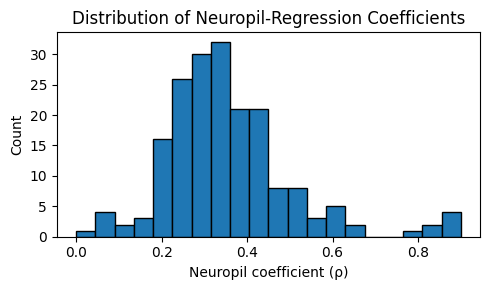

Min ρ = 0.00,  Max ρ = 0.90,  Median ρ = 0.34


In [36]:
# Histogram of ρ values
rho = data["rho_neuropil"]
plt.figure(figsize=(5, 3))
plt.hist(rho, bins=20, edgecolor="k")
plt.xlabel("Neuropil coefficient (ρ)")
plt.ylabel("Count")
plt.title("Distribution of Neuropil‐Regression Coefficients")
plt.tight_layout()
plt.show()

print(
    f"Min ρ = {rho.min():.2f},  Max ρ = {rho.max():.2f},  Median ρ = {np.median(rho):.2f}"
)

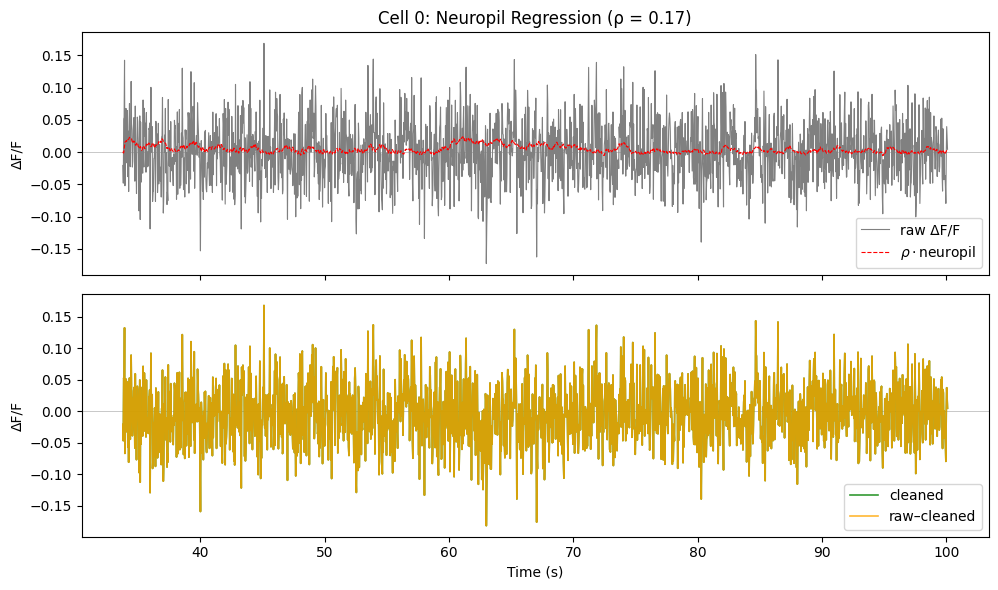

In [37]:
# pick a “good” cell to inspect
cell = data["good_cells"][0]

# pull out the first 2000 sparse‐noise frames
t0 = data["t_sparse"][:2000]
raw0 = data["dff_sparse"][cell, :2000]
np0 = data["neuropil_proxy"][cell, :2000]
rho0 = data["rho_neuropil"][cell]
clean = data["dff_regressed"][cell, :2000]
resid = raw0 - rho0 * np0

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# 1) zero baseline lines
for ax in (ax1, ax2):
    ax.axhline(0, color="k", lw=0.5, alpha=0.3)

# 2) Top panel: raw vs. scaled neuropil
ax1.plot(t0, raw0, lw=0.8, color="gray", label="raw ΔF/F")
ax1.plot(
    t0, rho0 * np0, lw=0.8, color="red", linestyle="--", label=r"$\rho\cdot$neuropil"
)
ax1.set_ylabel("ΔF/F")
ax1.set_title(f"Cell {cell}: Neuropil Regression (ρ = {rho0:.2f})")
ax1.legend(loc="lower right")

# 3) Bottom panel: cleaned vs. raw–cleaned residual
ax2.plot(t0, clean, lw=1.2, alpha=0.8, color="green", label="cleaned")
ax2.plot(t0, resid, lw=1.2, alpha=0.8, color="orange", label="raw–cleaned")
ax2.set_ylabel("ΔF/F")
ax2.set_xlabel("Time (s)")
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

# 3. Baseline Correction & Denoising

## 3.1 Drift Removal (60 s 10th‑percentile)

In [38]:
# Drift Removal via Sliding‐Window Percentile Baseline
from utils import sliding_baseline

# inputs: neuropil‐regressed ΔF/F and its timebase
dff_in = data["dff_regressed"]  # shape: (n_cells, n_time)
tvec = data["t_sparse"]  # shape: (n_time,)

# compute & subtract 10th‐percentile baseline over 60 s windows
baseline, dff_drift, win_frames = sliding_baseline(
    dff_in,
    tvec,
    window_sec=60,  # window length in seconds
    pct=10,  # percentile for baseline
    mode="nearest",  # boundary handling
)

# store for downstream steps
data.update(
    {
        "dff_baseline": baseline,
        "dff_drift": dff_drift,
        "drift_win": win_frames,
    }
)

# report
dt = np.median(np.diff(tvec))
print(f"Drift‐window: {win_frames} frames (~{win_frames*dt:.1f} s)")

Drift‐window: 1809 frames (~60.0 s)


## 3.2 QC of Drift Removal

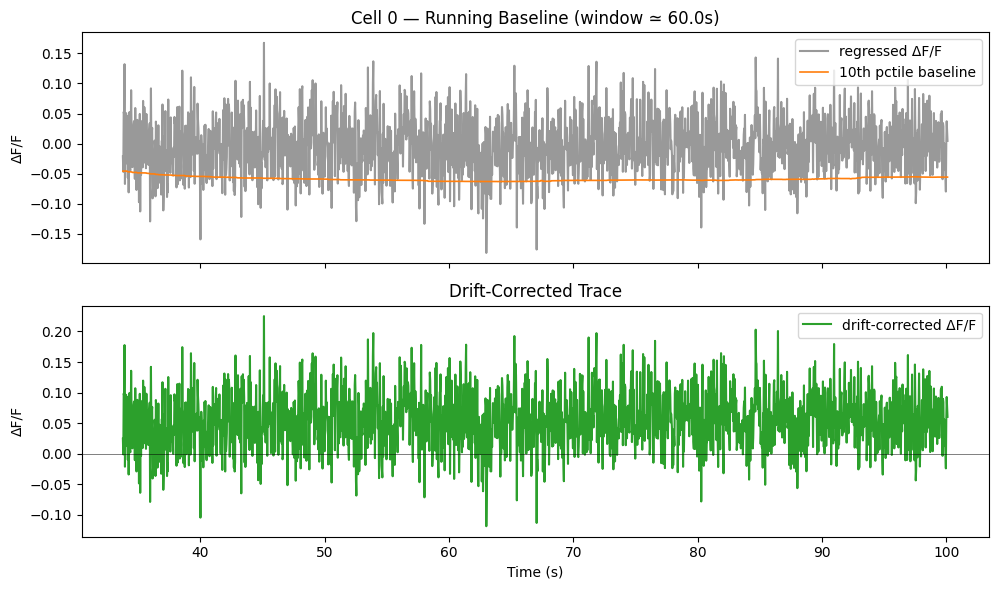

In [39]:
# Plot Baseline & Drift‐Corrected for One Example Cell

# pick a “good” cell for visualization
cell = data["good_cells"][0]
t0 = data["t_sparse"][:2000]
raw = data["dff_regressed"][cell, :2000]
bl = data["dff_baseline"][cell, :2000]
corr = data["dff_drift"][cell, :2000]

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# top: raw & running baseline
ax[0].plot(t0, raw, color="gray", label="regressed ΔF/F", alpha=0.8)
ax[0].plot(t0, bl, color="C1", label=f"{10}th pctile baseline", lw=1.2)
ax[0].set_ylabel("ΔF/F")
ax[0].set_title(
    f"Cell {cell} — Running Baseline (window ≃ {data['drift_win']*dt:.1f}s)"
)
ax[0].legend(loc="upper right")

# bottom: drift‐removed trace
ax[1].plot(t0, corr, color="C2", label="drift‑corrected ΔF/F")
ax[1].axhline(0, color="k", lw=0.5, alpha=0.7)
ax[1].set_ylabel("ΔF/F")
ax[1].set_xlabel("Time (s)")
ax[1].set_title("Drift‑Corrected Trace")
ax[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

## 3.3 Savitzky–Golay Smoothing (w=11, p=2)

In [40]:
# Savitzky–Golay Smoothing
from utils import smooth_dff_savgol

sg_window = 11  # frames
sg_poly = 2  # polynomial order

# pull the drift‑corrected traces
dff_dc = data["dff_drift"]  # shape (n_cells, n_time)

# smooth them
dff_smooth = smooth_dff_savgol(dff_dc, window=sg_window, polyorder=sg_poly)

# store back
data["dff_smooth"] = dff_smooth

print(f"Savitzky–Golay smoothing → window={sg_window}, polyorder={sg_poly}")
print("Smoothed shape:", dff_smooth.shape)

Savitzky–Golay smoothing → window=11, polyorder=2
Smoothed shape: (189, 66981)


## 3.4 QC of Smoothed Traces

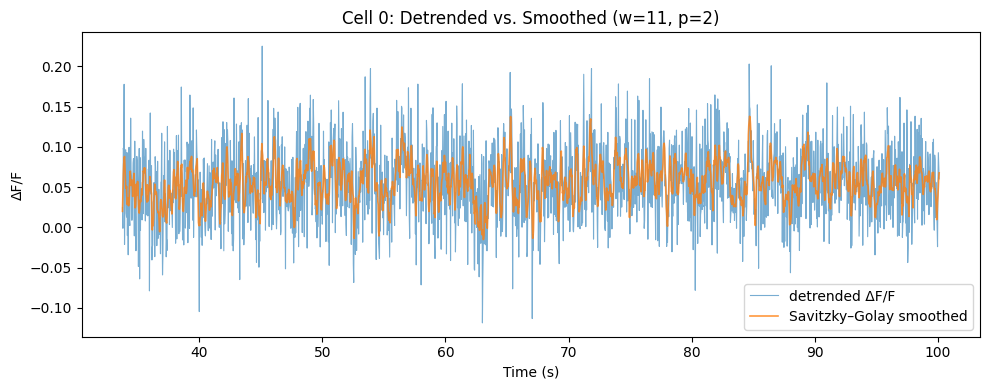

In [41]:
# QC: Example Raw vs. Smoothed Trace

cell = data["good_cells"][0]
t0 = data["t_sparse"][:2000]

raw0 = dff_dc[cell, :2000]
smooth0 = data["dff_smooth"][cell, :2000]

plt.figure(figsize=(10, 4))
plt.plot(t0, raw0, lw=0.8, alpha=0.6, label="detrended ΔF/F")
plt.plot(t0, smooth0, lw=1.2, alpha=0.8, label="Savitzky–Golay smoothed")
plt.xlabel("Time (s)")
plt.ylabel("ΔF/F")
plt.title(f"Cell {cell}: Detrended vs. Smoothed (w={sg_window}, p={sg_poly})")
plt.legend()
plt.tight_layout()
plt.show()

# 5 Final QC on Cleaned Data

## 5.1 Compute Clean ΔF/F QC Metrics

In [42]:
# QC on Final Cleaned ΔF/F
from utils import compute_qc_metrics


# 1) Pull in your final cleaned traces
dff_clean = data["dff_smooth"]  # shape (n_cells, n_time)

# 2) Compute per‑cell variance & S NR
var_clean, snr_clean = compute_qc_metrics(dff_clean)

# 3) Compute 10th‐percentile thresholds
var_thr_clean = np.percentile(var_clean, 10)
snr_thr_clean = np.percentile(snr_clean, 10)

# 4) Store them for downstream
data.update(
    {
        "var_clean": var_clean,
        "snr_clean": snr_clean,
        "var_thr_clean": var_thr_clean,
        "snr_thr_clean": snr_thr_clean,
    }
)

# 5) Quick summary
n_pass = np.sum((var_clean > var_thr_clean) & (snr_clean > snr_thr_clean))
print(f"Cleaned ΔF/F QC thresholds: var>{var_thr_clean:.3f}, snr>{snr_thr_clean:.3f}")
print(f"Cells passing cleaned‐QC: {n_pass}/{len(var_clean)}")

Cleaned ΔF/F QC thresholds: var>0.001, snr>1.770
Cells passing cleaned‐QC: 151/189


## 5.2 Compare Raw vs Clean Variance & SNR Distributions

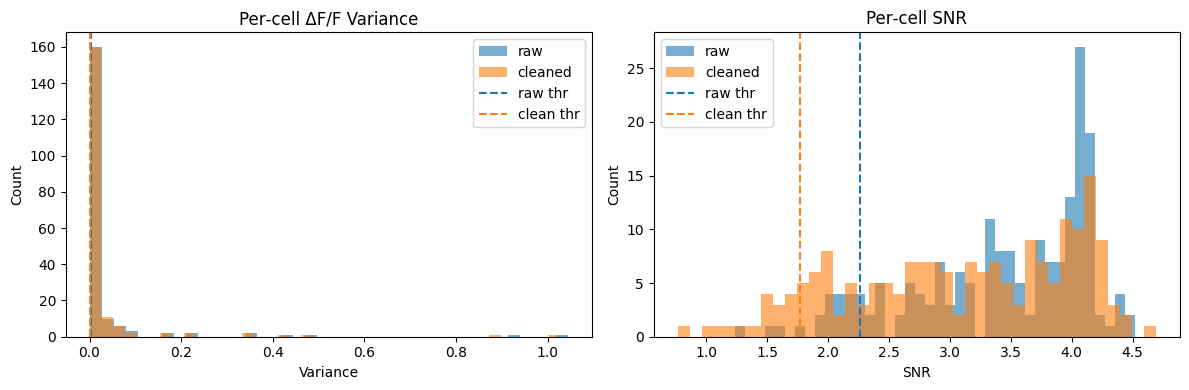

In [43]:
# Histograms: raw vs. cleaned variance & SNR
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Variance
axs[0].hist(data["var_raw"], bins=40, alpha=0.6, label="raw")
axs[0].hist(data["var_clean"], bins=40, alpha=0.6, label="cleaned")
axs[0].axvline(data["var_thr_raw"], color="C0", linestyle="--", label="raw thr")
axs[0].axvline(data["var_thr_clean"], color="C1", linestyle="--", label="clean thr")
axs[0].set_title("Per‑cell ΔF/F Variance")
axs[0].set_xlabel("Variance")
axs[0].set_ylabel("Count")
axs[0].legend()

# SNR
axs[1].hist(data["snr_raw"], bins=40, alpha=0.6, label="raw")
axs[1].hist(data["snr_clean"], bins=40, alpha=0.6, label="cleaned")
axs[1].axvline(data["snr_thr_raw"], color="C0", linestyle="--", label="raw thr")
axs[1].axvline(data["snr_thr_clean"], color="C1", linestyle="--", label="clean thr")
axs[1].set_title("Per‑cell SNR")
axs[1].set_xlabel("SNR")
axs[1].set_ylabel("Count")
axs[1].legend()

plt.tight_layout()
plt.show()

## 5.3 Full‐Pipeline Trace Overlay

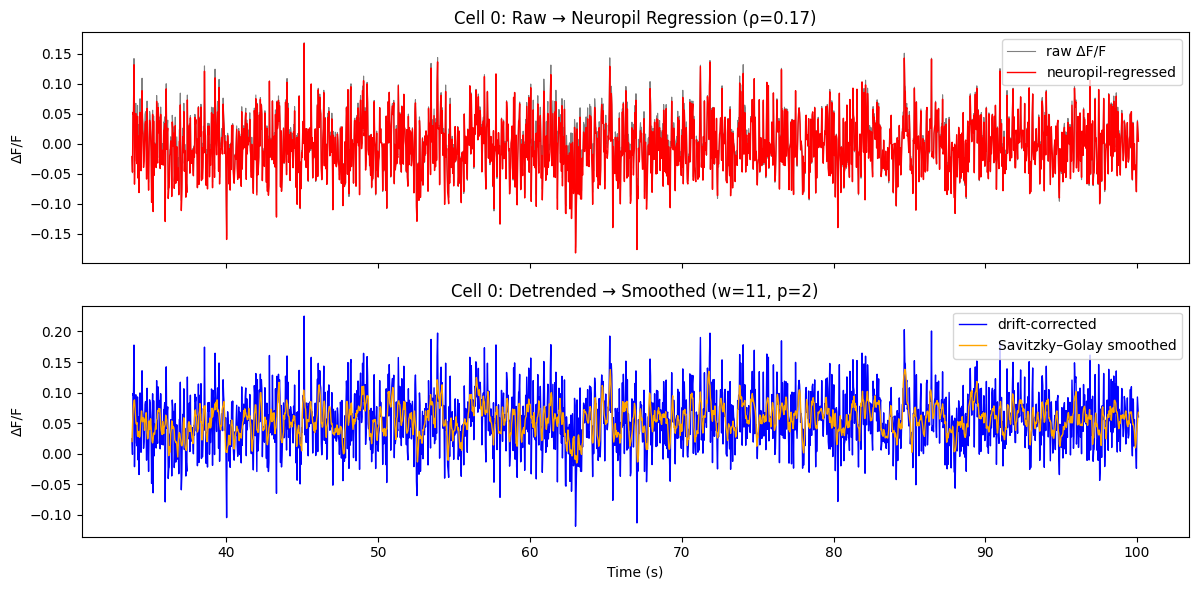

In [44]:
# QC — Full Cleaning Pipeline Overlay (first 2 000 frames)


# pick one good cell for demonstration
cell = data["good_cells"][0]
n0 = 2000  # number of frames

# pull out the four versions of this cell’s trace
t0 = data["t_sparse"][:n0]
raw0 = data["dff_sparse"][cell, :n0]
reg0 = data["dff_regressed"][cell, :n0]
detr0 = data["dff_drift"][cell, :n0]  # drift‑corrected
smooth0 = data["dff_smooth"][cell, :n0]  # Savitzky–Golay smoothed

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# top: raw vs. neuropil‑regressed
ax1.plot(t0, raw0, color="gray", linewidth=0.8, label="raw ΔF/F")
ax1.plot(t0, reg0, color="red", linewidth=1, label="neuropil‑regressed")
ax1.set_ylabel("ΔF/F")
ax1.set_title(
    f"Cell {cell}: Raw → Neuropil Regression (ρ={data['rho_neuropil'][cell]:.2f})"
)
ax1.legend(loc="upper right")

# bottom: drift‑corrected vs. smoothed
ax2.plot(t0, detr0, color="blue", linewidth=1, label="drift‑corrected")
ax2.plot(t0, smooth0, color="orange", linewidth=1, label="Savitzky–Golay smoothed")
ax2.set_ylabel("ΔF/F")
ax2.set_xlabel("Time (s)")
ax2.set_title(f"Cell {cell}: Detrended → Smoothed (w={sg_window}, p={sg_poly})")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

## 6. Spike Inference & Hyperparameter Sweeps

## 6.1 Estimate per‑cell noise for deconvolution

In [45]:
import utils as ae

# Noise Estimation

dff_for_noise = data["dff_smooth"]
dt = np.median(np.diff(data["t_sparse"]))
print(f"dt = {dt:.5f} s (≈{1.0/dt:.1f} Hz)")

# per‑frame σ (OASIS expects noise per sample)
noise_sigma = ae.estimate_noise_sigma(dff_for_noise)
data.update({"noise_sigma": noise_sigma, "noise_dt": dt})

print("Estimated noise_sigma for each cell:")
print(noise_sigma[:5])

dt = 0.03317 s (≈30.1 Hz)
Estimated noise_sigma for each cell:
[0.00790449 0.00743161 0.00830615 0.00931993 0.00912261]


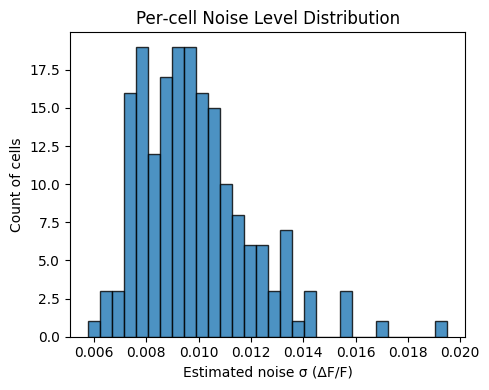

In [46]:
# QC — Distribution of Estimated Noise σ

sigma = data["noise_sigma"]

plt.figure(figsize=(5, 4))
plt.hist(sigma, bins=30, edgecolor="k", alpha=0.8)
plt.xlabel("Estimated noise σ (ΔF/F)")
plt.ylabel("Count of cells")
plt.title("Per‑cell Noise Level Distribution")
plt.tight_layout()
plt.show()

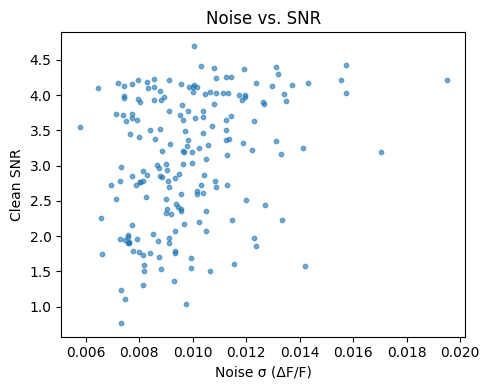

In [47]:
# QC — Noise vs. SNR
plt.figure(figsize=(5, 4))
plt.scatter(data["noise_sigma"], data["snr_clean"], s=10, alpha=0.6)
plt.xlabel("Noise σ (ΔF/F)")
plt.ylabel("Clean SNR")
plt.title("Noise vs. SNR")
plt.tight_layout()
plt.show()

## 6.2 Spike Inference — OASIS Deconvolution

In [48]:
# OASIS Deconvolution
dff_in = data["dff_smooth"]
dt = data["noise_dt"]
fs = 1.0 / dt

oas_res = ae.deconvolve_oasis(
    dff=dff_in, fs=fs, penalty=1, g_init=None, optimize_g=False
)

data.update(
    {
        "oasis_c": oas_res["c"],
        "oasis_s": oas_res["s"],
        "oasis_b": oas_res["b"],
        "oasis_g": oas_res["g"],
        "oasis_fs": fs,
    }
)

total_time = dff_in.shape[1] * dt
event_rate = oas_res["s"].sum(axis=1) / total_time
data["oasis_rate"] = event_rate

print("OASIS deconvolution complete")
print("Example AR(1) g:", np.round(oas_res["g"][:5], 3))
print("Example rates (Hz):", np.round(event_rate[:5], 3))

/home/andi/anaconda3/envs/calcium-env/lib/python3.11/site-packages/oasis/functions.py:817: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[np.arange(lags)],


OASIS deconvolution complete
Example AR(1) g: [0.91  0.812 0.884 0.885 0.801]
Example rates (Hz): [0.141 0.246 0.203 0.219 0.318]


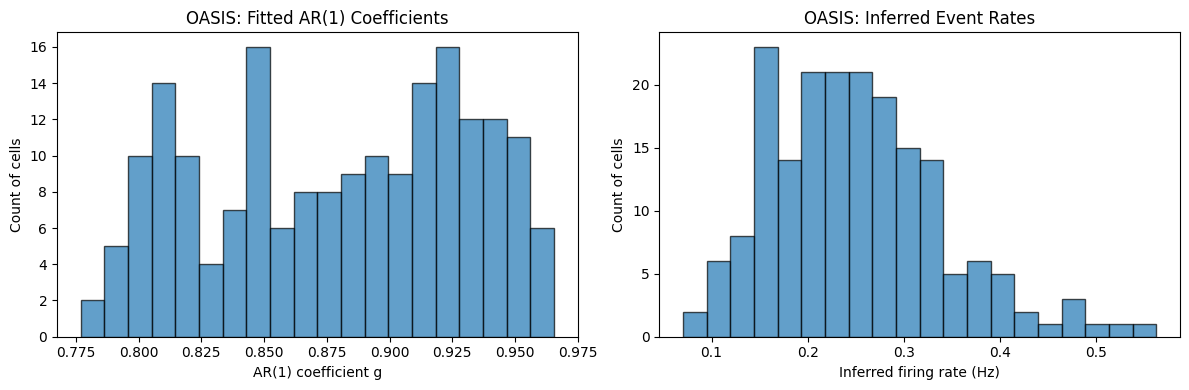

In [49]:
# QC — AR(1) coefficients & event‐rate distributions

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# AR(1) g
axs[0].hist(data["oasis_g"], bins=20, edgecolor="k", alpha=0.7)
axs[0].set_xlabel("AR(1) coefficient g")
axs[0].set_ylabel("Count of cells")
axs[0].set_title("OASIS: Fitted AR(1) Coefficients")

# Event rates
axs[1].hist(data["oasis_rate"], bins=20, edgecolor="k", alpha=0.7)
axs[1].set_xlabel("Inferred firing rate (Hz)")
axs[1].set_ylabel("Count of cells")
axs[1].set_title("OASIS: Inferred Event Rates")

plt.tight_layout()
plt.show()

## 6.3 Compute Reconstruction & Fit Metrics

In [50]:
# Fit‑Quality Scoring
from sklearn.metrics import r2_score
from utils import reconvolve_calcium_kernel

s_hat = data["oasis_s"]
g_hat = data["oasis_g"]
b_hat = data["oasis_b"]
y_clean = data["dff_smooth"]
dt = data["noise_dt"]
n_cells, n_t = s_hat.shape

# reconstruct via AR(1)
y_rec = np.zeros_like(y_clean)
for i in range(n_cells):
    y_rec[i] = reconvolve_calcium_kernel(s_hat[i], g_hat[i], b_hat[i])

# compute metrics
ss_res = np.sum((y_clean - y_rec) ** 2, axis=1)
ss_tot = np.sum((y_clean - y_clean.mean(axis=1, keepdims=True)) ** 2, axis=1)
r2 = 1 - ss_res / ss_tot
mse = ss_res / n_t

event_counts = s_hat.sum(axis=1)
rates_hz = event_counts / (n_t * dt)

fit_qc = pd.DataFrame(
    {
        "r2": r2,
        "mse": mse,
        "event_count": event_counts.astype(int),
        "rate_hz": rates_hz,
        "g_ar1": g_hat,
    },
    index=pd.Index(np.arange(n_cells), name="cell"),
)

data["fit_qc"] = fit_qc
print(f"Computed fit metrics for {n_cells} cells.")
display(fit_qc.head())

Computed fit metrics for 189 cells.


r2       mse  event_count   rate_hz     g_ar1
cell                                                     
0     0.957045  0.000109          314  0.141400  0.909569
1     0.928566  0.000049          546  0.245809  0.812061
2     0.951188  0.000118          449  0.202521  0.884358
3     0.961551  0.000132          486  0.218756  0.884707
4     0.912741  0.000079          706  0.318021  0.800697

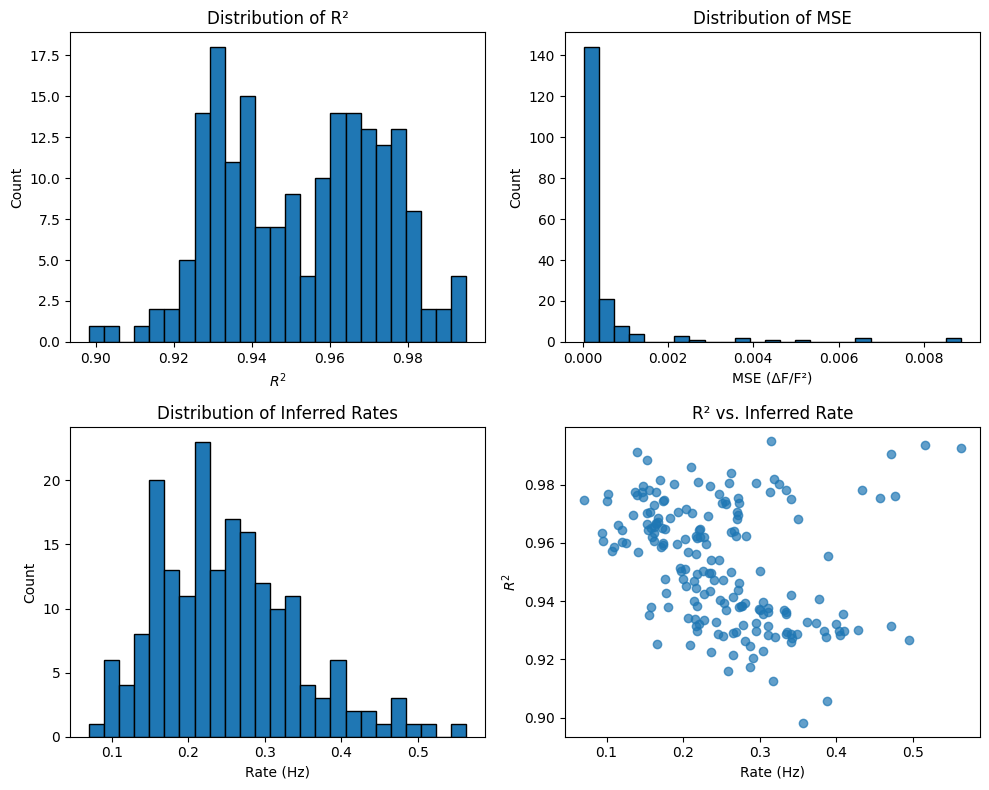

In [51]:
# Visualize Fit‑Quality Distributions
df = data["fit_qc"]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# R² histogram
axs[0, 0].hist(df["r2"], bins=25, edgecolor="k")
axs[0, 0].set_title("Distribution of R²")
axs[0, 0].set_xlabel("$R^2$")
axs[0, 0].set_ylabel("Count")

# MSE histogram
axs[0, 1].hist(df["mse"], bins=25, edgecolor="k")
axs[0, 1].set_title("Distribution of MSE")
axs[0, 1].set_xlabel("MSE (ΔF/F²)")
axs[0, 1].set_ylabel("Count")

# Event‐rate histogram
axs[1, 0].hist(df["rate_hz"], bins=25, edgecolor="k")
axs[1, 0].set_title("Distribution of Inferred Rates")
axs[1, 0].set_xlabel("Rate (Hz)")
axs[1, 0].set_ylabel("Count")

# R² vs. rate scatter
axs[1, 1].scatter(df["rate_hz"], df["r2"], alpha=0.7)
axs[1, 1].set_title("R² vs. Inferred Rate")
axs[1, 1].set_xlabel("Rate (Hz)")
axs[1, 1].set_ylabel("$R^2$")

plt.tight_layout()
plt.show()

## 6.4 Hyperparamter Sweeps

In [52]:
# # Hyperparameter Sweep
# from utils import sweep_oasis_params

# # random search: N=25 pairs
# rng = np.random.default_rng(0)
# N_draws = 25
# g_rand = rng.uniform(0.6, 0.95, size=N_draws)
# lam_rand = np.exp(rng.uniform(np.log(0.1), np.log(3.0), size=N_draws))
# params = list(zip(g_rand, lam_rand))

# cells_to_test = data["good_cells"][:50]
# fs_sweep = 1.0 / np.median(np.diff(data["t_sparse"]))

# results_df = sweep_oasis_params(
#     dff_clean=data["dff_smooth"],
#     fs=fs_sweep,
#     noise_sigma=data["noise_sigma"],
#     params=params,
#     cells=cells_to_test,
#     n_jobs=-1,
# )

# summary = (
#     results_df.groupby(["g", "lam"])["r2"]
#     .mean()
#     .reset_index()
#     .sort_values("r2", ascending=False)
# )
# print("Top 10 parameter combos by avg R²:")
# print(summary.head(10))

### RESULTS #####
# Top 10 parameter combos by avg R²:
#           g       lam        r2
# 0  0.600958  0.521961  0.981948
# 1  0.605785  1.029505  0.981858
# 2  0.609912  2.065585  0.981780
# 3  0.611755  2.397152  0.981745
# 4  0.614341  2.810689  0.981690
# 5  0.643499  0.216541  0.980871
# 6  0.661479  0.698584  0.980201
# 7  0.694425  2.971666  0.978656
# 8  0.704899  0.315599  0.978066
# 9  0.747941  0.378851  0.974936

In [53]:
# # Final OASIS with per-cell g optimization
# from tqdm.notebook import tqdm
# import ae_utils as ae


# dff_clean = data["dff_smooth"]
# fs = data["oasis_fs"]  # 1/dt
# lam_opt = 0.5220  # from sweep
# g_init = 0.6010  # from sweep
# n_cells, n_t = dff_clean.shape

# # pre-allocate output arrays
# c_opt = np.zeros_like(dff_clean)
# s_opt = np.zeros_like(dff_clean)
# b_opt = np.zeros(n_cells, float)
# g_opt = np.zeros(n_cells, float)

# print("Running optimized deconvolution for each cell:")
# for i in tqdm(range(n_cells), desc="OASIS per cell"):
#     out = ae.deconvolve_oasis(
#         dff=dff_clean[i : i + 1, :],  # single-cell slice
#         fs=fs,
#         penalty=lam_opt,
#         g_init=g_init,
#         optimize_g=True,
#     )
#     c_opt[i] = out["c"][0]
#     s_opt[i] = out["s"][0]
#     b_opt[i] = out["b"][0]
#     g_opt[i] = out["g"][0]

# # unpack into your data dict
# data["oas_c_opt"] = c_opt
# data["oas_s_opt"] = s_opt
# data["oas_b_opt"] = b_opt
# data["oas_g_opt"] = g_opt

# # now recompute true fit metrics
# r2_opt, mse_opt, event_counts, rate_hz = ae.compute_fit_metrics(
#     y_true=dff_clean,
#     s_hat=data["oas_s_opt"],
#     g_hat=data["oas_g_opt"],
#     b_hat=data["oas_b_opt"],
#     fs=fs,
# )

# # update your QC table
# data["fit_qc"]["r2"] = r2_opt
# data["fit_qc"]["mse"] = mse_opt
# data["fit_qc"]["event_count"] = event_counts
# data["fit_qc"]["rate_hz"] = rate_hz

# print("Recomputed fit metrics on optimized traces.")
# display(data["fit_qc"].head())


#### RESULTS #####
# Running optimized deconvolution for each cell:
# Error displaying widget: model not found
# Recomputed fit metrics on optimized traces.
# r2	mse	event_count	rate_hz	g_ar1
# cell
# 0	0.990210	0.000025	958	0.431190	0.892800
# 1	0.961720	0.000026	1042	0.468998	0.802260
# 2	0.983970	0.000039	1289	0.580171	0.835849
# 3	0.990251	0.000034	1349	0.607176	0.866176
# 4	0.947841	0.000047	1242	0.559016	0.803398

In [54]:
import numpy as np
import pandas as pd


def get_clean_stim_mapping(stim_table, t_full, mask_sparse, n_stim):
    """
    Builds a full‐length and sparse clean mapping from time to stimulus index,
    filling any gaps so that there are no -1s or out-of-range values.

    Args:
        stim_table (np.ndarray or pd.DataFrame): columns [frame, start, end] or [stim_idx, onset, duration].
        t_full (np.ndarray): full time vector (length = total timesteps).
        mask_sparse (np.ndarray of bool): mask of sparse‐selected timesteps.
        n_stim (int): number of stimulus frames.

    Returns:
        stim_id_full_clean (np.ndarray[int], shape=(len(t_full),)):
            Cleaned stimulus index at every timestep, no -1 or out of range.
        stim_id_clean (np.ndarray[int], shape=(mask_sparse.sum(),)):
            Subset for sparse‐selected timesteps.
    """
    # Step 1: build raw full‐length map using original function ---
    # It expects columns ['frame','start','end']
    active = np.full(len(t_full), -1, dtype=int)
    if isinstance(stim_table, np.ndarray):
        rows = [tuple(r) for r in stim_table]
    else:
        rows = stim_table[["frame", "start", "end"]].itertuples(index=False, name=None)
    for frame_id, start_idx, end_idx in rows:
        fid = int(frame_id)
        s = max(int(start_idx), 0)
        e = min(int(end_idx), len(t_full))
        if s < e:
            active[s:e] = fid
    stim_id_full = active

    # Step 2: mask invalid entries (−1 or ≥ n_stim) ---
    invalid = (stim_id_full < 0) | (stim_id_full >= n_stim)

    # Step 3: convert to float and mark invalid as NaN ---
    fm = stim_id_full.astype(float)
    fm[invalid] = np.nan

    # Step 4: forward‐fill then backward‐fill NaNs ---
    s = pd.Series(fm)
    s_ff = s.ffill().bfill()

    # Step 5: back to int, final check ---
    stim_id_full_clean = s_ff.astype(int).values
    assert np.all(
        (stim_id_full_clean >= 0) & (stim_id_full_clean < n_stim)
    ), "Clean full mapping has out‑of‑range indices!"

    # Step 6: extract sparse subset
    stim_id_clean = stim_id_full_clean[mask_sparse]

    # Return both maps
    return stim_id_full_clean, stim_id_clean


# assuming ⁠ data ⁠ is in your namespace:
n_stim = data["stim"].shape[0]
t_full = data["t"]
mask_sparse = data["mask_sparse"]
stim_full_clean, stim_clean = get_clean_stim_mapping(
    data["stim_table"], t_full, mask_sparse, n_stim
)

print(
    "Full map cleaned:",
    stim_full_clean.shape,
    "| Unique IDs:",
    np.unique(stim_full_clean)[:10],
    "... total:",
    np.unique(stim_full_clean).size,
)
print(
    "Sparse map:",
    stim_clean.shape,
    "| Any invalid? ",
    np.any((stim_clean < 0) | (stim_clean >= n_stim)),
)
# Overwrite
data["stim_id"] = stim_full_clean
data["stim_id_clean"] = stim_clean

Full map cleaned: (105968,) | Unique IDs: [0 1 2 3 4 5 6 7 8 9] ... total: 8880
Sparse map: (66981,) | Any invalid?  False


In [55]:
preprocessed_oasis_data = np.load("data/preprocessed/ae_data_snapshot.npz")
preprocessed_oasis_data.keys()

KeysView(NpzFile 'data/preprocessed/ae_data_snapshot.npz' with keys: dff, t, stim, stim_table, stim_epoch_table...)

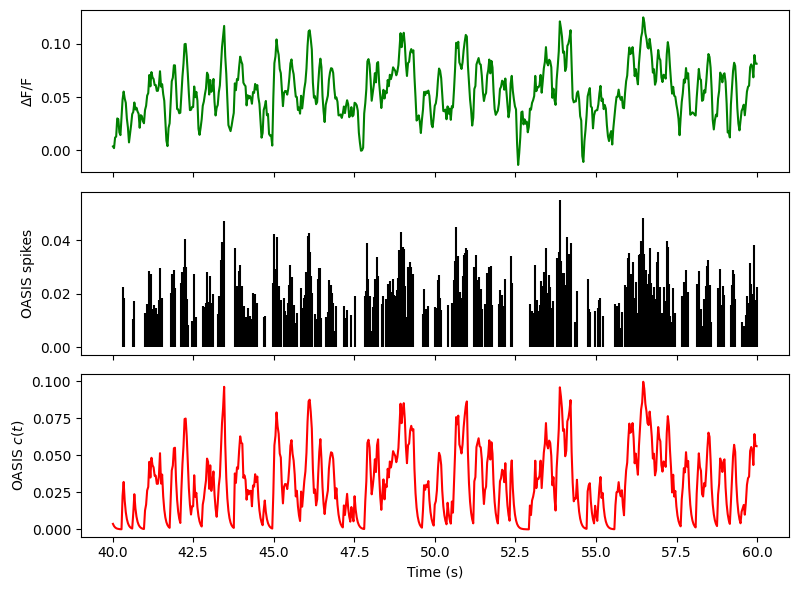

In [56]:
import matplotlib.pyplot as plt

d = preprocessed_oasis_data
cell = int(data["good_cells"][0])

# pick absolute window from 40 s to 60 s (within 33.78–3517 s)
t0, t1 = 40.0, 60.0

t = d["t_sparse"]
y = d["dff_smooth"][cell, :]
s = d["oas_s_opt"][cell, :]
c = d["oas_c_opt"][cell, :]

mask = (t >= t0) & (t <= t1)
t_win = t[mask]
y_win = y[mask]
s_win = s[mask]
c_win = c[mask]

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
ax0.plot(t_win, y_win, color="green")
ax0.set_ylabel("ΔF/F")
ax1.vlines(t_win[s_win > 0], 0, s_win[s_win > 0], color="black")
ax1.set_ylabel("OASIS spikes")
ax2.plot(t_win, c_win, color="red")
ax2.set_ylabel("OASIS $c(t)$")
ax2.set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

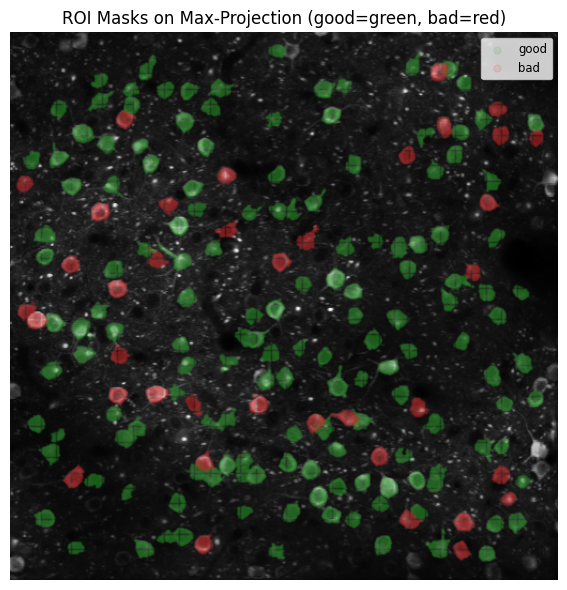

In [57]:
# QC — ROI Masks overlaid on Max‑Projection
max_proj = data["max_projection"]
masks = data["roi_masks"]
good = set(data["good_cells"])
bad = set(data["bad_cells"])

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(max_proj, cmap="gray")
# plot good cells in green, bad in red
for cell_set, color in [(good, "C2"), (bad, "C3")]:
    ys, xs = np.nonzero(np.sum(masks[list(cell_set)], axis=0))
    ax.scatter(
        xs, ys, s=1, alpha=0.1, color=color, label=("good" if color == "C2" else "bad")
    )
ax.set_title("ROI Masks on Max‑Projection (good=green, bad=red)")
ax.axis("off")
ax.legend(markerscale=5, fontsize="small")
plt.tight_layout()
plt.show()

## Tuning Function Fitting using ML - LNP

In [58]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import utils as U
# import importlib
# import os
# import glob

# importlib.reload(U)

# use_cached_data = True

# if use_cached_data:
#     try:
#         namespace = "aakarsh"
#         background_dir = f'data/{namespace}/background/'
#         list_of_background_files = glob.glob(os.path.join(background_dir, '*.npz'))
#         if not list_of_background_files:
#             raise FileNotFoundError(f"No background data files found in '{background_dir}'")

#         latest_background_file = max(list_of_background_files, key=os.path.getctime)
#         print(f"Loading latest background data from: {latest_background_file}")

#         stim_data = np.load(latest_background_file, allow_pickle=True)
#         stim_filtered = stim_data['stim_filtered']
#         stim_table_filtered_df = pd.DataFrame(stim_data['stim_table_filtered'], columns=stim_data['stim_table_columns'])

#         spike_inference_dir = f'data/{namespace}/preprocessed/'
#         list_of_spike_files = glob.glob(os.path.join(spike_inference_dir, '*.npz'))
#         if not list_of_spike_files:
#             raise FileNotFoundError(f"No spike inference files found in '{spike_inference_dir}'")

#         latest_spike_file = max(list_of_spike_files, key=os.path.getctime)
#         print(f"Loading latest spike inference data from: {latest_spike_file}")

#         spike_data = np.load(latest_spike_file, allow_pickle=True)
#         print(spike_data.keys())

#         inferred_spikes = spike_data['spike_counts']
#         time_vector = spike_data['time_vector']
#         sampling_rate = spike_data['sampling_frequency']

#         data  = U.load_data()# Load the latest spike inference data
#         data  = U.preprocess_data(data)  # Preprocess the data

#     except FileNotFoundError as e:
#         print(f"ERROR: Could not find a necessary input file: {e}")
#         print("Please ensure you have run the previous notebooks (00 and 02) and saved their outputs correctly.")
#         raise

In [59]:
# importlib.reload(
#     U
# )

# inferred_spikes = spike_data["spike_counts"]
# binned_spikes, presented_frame_ids = (
#     np.array(inferred_spikes, dtype=np.float64),
#     active_stim_per_timestep,
# )  # stimulus data is already binned.

# #
# assert (
#     np.sum(presented_frame_ids[presented_frame_ids == -1]) == 0
# ), "There are still -1 values in presented_frame_ids. Please check the filtering step."

In [60]:
#  Filter presented frame_ids and binned spikes by removing indexes where presented_Frame_ids is -1
binned_spikes = d["oas_s_opt"]
presented_frame_ids = data["stim_id_clean"]
print(
    f"binned_spikes.shape: {binned_spikes.shape}, presented_frame_ids.shape: {presented_frame_ids.shape}"
)

binned_spikes.shape: (189, 66981), presented_frame_ids.shape: (66981,)


In [61]:
# Convert the stimulus to binary matrices for 'ON' and 'OFF' stimuli, these are easier to train and give better receptive field estimates.
import an_utils as U

flattened_stim, stim_h, stim_w = U.prepare_stimulus_matrix_from_ids(
    presented_frame_ids, full_stim_movie=data["stim"]
)
print(
    f"Flattened stimulus shape: {flattened_stim.shape}, Stimulus height: {stim_h}, Stimulus width: {stim_w}"
)

# Create a copy of the original flattened stimulus matrix
flattened_on_stimuli = flattened_stim.copy()
flattened_off_stimuli = flattened_stim.copy()

# For the 'ON' matrix, set all 'OFF' pixels (<= 127) to zero
flattened_on_stimuli[flattened_on_stimuli <= 127] = 0
flattened_on_stimuli[flattened_on_stimuli > 127] = 1

# For the 'OFF' matrix, set all 'ON' pixels (> 127) to zero
flattened_off_stimuli[flattened_off_stimuli < 127] = 1
flattened_off_stimuli[flattened_off_stimuli >= 127] = 0

# --- Verification ---
print(f"Flattened Stimulus Shape: {flattened_stim.shape}")
print(f"Flattened On Stimuli Shape: {flattened_on_stimuli.shape}")
print(f"Flattened Off Stimuli Shape: {flattened_off_stimuli.shape}")

# These assertions will now pass because the shape is preserved
assert (
    flattened_on_stimuli.shape == flattened_stim.shape
), "The shape of flattened_on_stimuli does not match the shape of flattened_stim."
assert (
    flattened_off_stimuli.shape == flattened_stim.shape
), "The shape of flattened_off_stimuli does not match the shape of flattened_stim."

print("\nAssertions passed! The shapes are now correct.")

Preparing stimulus matrix from frame IDs...
Stimulus matrix preparation complete. Shape: (448, 66981)
Flattened stimulus shape: (448, 66981), Stimulus height: 16, Stimulus width: 28
Flattened Stimulus Shape: (448, 66981)
Flattened On Stimuli Shape: (448, 66981)
Flattened Off Stimuli Shape: (448, 66981)

Assertions passed! The shapes are now correct.


/home/andi/anaconda3/envs/calcium-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


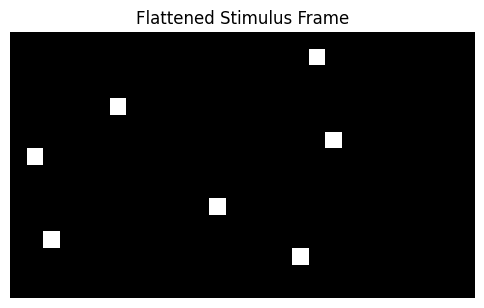

In [62]:
# Plot a single flattened stimulus frame
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(flattened_on_stimuli[:, 0].reshape(stim_h, stim_w), cmap="gray")
plt.title("Flattened Stimulus Frame")
plt.axis("off")
plt.show()

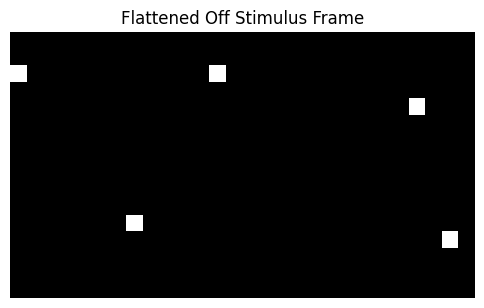

In [63]:
# Plot a single flattened stimulus frame
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(flattened_off_stimuli[:, 0].reshape(stim_h, stim_w), cmap="gray")
plt.title("Flattened Off Stimulus Frame")
plt.axis("off")
plt.show()

In [68]:
import importlib
import an_utils as U

importlib.reload(
    U
)  # Reload utils to ensure you're using the latest version of your functions
lags_to_test = np.array(list(range(10)))
selected_neurons = np.arange(binned_spikes.shape[0])  # Select all neurons for now
selected_neurons = [0, 1, 2]
all_rfs_spatiotemporal_on = U.fit_all_neurons_rfs_parallel(
    binned_spikes, flattened_on_stimuli, lags_to_test, selected_neurons=selected_neurons
)


Step 3 & 4: Fitting spatio-temporal receptive fields in parallel using 3 cores...


Fitting neurons: 100%|██████████| 3/3 [00:00<00:00, 497.11it/s]


Fitting complete.


In [69]:
# ------ END LNP MODEL FITTING ------------------#
all_rfs_spatiotemporal_on_np = np.array(all_rfs_spatiotemporal_on, dtype=np.float64)

In [70]:
all_rfs_spatiotemporal_on_np.shape

(3, 448, 10)

In [ ]:
num_lags = len(lags_to_test)
num_neurons = data["dff"].shape[0]
# 2. Create a single figure with a grid of subplots
# The grid will have 'num_neurons' rows and 'num_lags' columns.
fig, axes = plt.subplots(
    num_neurons,
    num_lags,
    figsize=(num_lags * 2, num_neurons * 2.2),
    squeeze=False,  # Always return a 2D array for axes
)

fig.suptitle("Spatio-Temporal Receptive Fields (All Neurons) - Simple LNP", fontsize=16)

# 3. Loop through each neuron and its corresponding row of axes
for neuron_idx, w_flat in enumerate(all_rfs_spatiotemporal_on_np):
    neuron_id = selected_neurons[neuron_idx]

    # Reshape the flattened weights to (time, height, width)
    strf = w_flat.reshape(num_lags, stim_h, stim_w)
    # Normalize color scale per-neuron for fair comparison across its own lags
    vmin, vmax = strf.min(), strf.max()

    # Set the y-label for the row to identify the neuron
    axes[neuron_idx, 0].set_ylabel(
        f"Neuron {neuron_id}",
        rotation=0,
        size="large",
        labelpad=40,  # Move label to the left
        ha="right",
        va="center",
    )

    # Loop through each time lag and its column
    for lag_idx in range(num_lags):
        ax = axes[neuron_idx, lag_idx]

        # Plot the spatial receptive field at this lag
        ax.imshow(strf[lag_idx], cmap="bwr", vmin=vmin, vmax=vmax)
        ax.axis("off")  # Hide axis ticks and borders

        # --- CHANGE ---
        # Set a title for every subplot to show its corresponding lag.
        # The 'if' condition that restricted this to the first row is removed.
        ax.set_title(f"Neuron {neuron_id} Lag {lag_idx} ")

# 4. Adjust layout and display the single plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to make space for suptitle
plt.show()

In [ ]:
all_rfs_spatiotemporal_on_np.shape

(189, 448, 10)

# Tuning Function with STA

# Tuning Function with Spline Basis in RFEST

In [ ]:
# use_cached_data = True


# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import an_utils as U
# import importlib
# import os
# import glob

# # Reload utils to ensure you're using the latest version of your functions
# importlib.reload(U)

# if use_cached_data:
#     try:
#         # ACTION: Change 'aakarsh' to your namespace if needed.
#         namespace = "aakarsh"

#         # --- Load the latest output from the preprocessing notebook (00-background.ipynb) ---
#         background_dir = f"data/{namespace}/background/"
#         list_of_background_files = glob.glob(os.path.join(background_dir, "*.npz"))
#         if not list_of_background_files:
#             raise FileNotFoundError(
#                 f"No background data files found in '{background_dir}'"
#             )

#         latest_background_file = max(list_of_background_files, key=os.path.getctime)
#         print(f"Loading latest background data from: {latest_background_file}")

#         stim_data = np.load(latest_background_file, allow_pickle=True)
#         stim_filtered = stim_data["stim_filtered"]
#         stim_table_filtered_df = pd.DataFrame(
#             stim_data["stim_table_filtered"], columns=stim_data["stim_table_columns"]
#         )

#         # --- Load the latest output from the spike inference notebook (02-spike-inference.ipynb) ---
#         spike_inference_dir = f"data/{namespace}/preprocessed/"
#         list_of_spike_files = glob.glob(os.path.join(spike_inference_dir, "*.npz"))
#         if not list_of_spike_files:
#             raise FileNotFoundError(
#                 f"No spike inference files found in '{spike_inference_dir}'"
#             )

#         latest_spike_file = max(list_of_spike_files, key=os.path.getctime)
#         print(f"Loading latest spike inference data from: {latest_spike_file}")

#         spike_data = np.load(latest_spike_file, allow_pickle=True)
#         print(spike_data.keys())

#         inferred_spikes = spike_data["spike_counts"]
#         time_vector = spike_data["time_vector"]
#         sampling_rate = spike_data["sampling_frequency"]

#         data = U.load_data()  # Load the latest spike inference data
#         data = U.preprocess_data(data)  # Preprocess the data

#     except FileNotFoundError as e:
#         print(f"ERROR: Could not find a necessary input file: {e}")
#         print(
#             "Please ensure you have run the previous notebooks (00 and 02) and saved their outputs correctly."
#         )
#         raise

In [ ]:
# active_stim_per_timestep = U.get_active_stimulus_per_timestep(
#     data["stim_table"], total_timesteps=len(data["t"])
# )

In [ ]:
# importlib.reload(
#     U
# )  # Reload utils to ensure you're using the latest version of your functions

# # Prepare the stimulus matrix from the presented frame IDs
# # Reload utils to ensure you're using the latest version of your functions

# inferred_spikes = spike_data["spike_counts"]
# binned_spikes, presented_frame_ids = (
#     np.array(inferred_spikes, dtype=np.float64),
#     active_stim_per_timestep,
# )  # stimulus data is already binned.

# # Filter presented frame_ids and binned spikes by removing indexes where presented_Frame_ids is -1
# binned_spikes = binned_spikes[:, presented_frame_ids != -1]
# presented_frame_ids = presented_frame_ids[presented_frame_ids != -1]
# print(
#     f"binned_spikes.shape: {binned_spikes.shape}, presented_frame_ids.shape: {presented_frame_ids.shape}"
# )
# assert (
#     np.sum(presented_frame_ids[presented_frame_ids == -1]) == 0
# ), "There are still -1 values in presented_frame_ids. Please check the filtering step."

In [ ]:
### OVERWOTE THE binned_spikes wand frame ids here.
# load npz file with the binned spikes and frame ids
binned_spikes = d["oas_s_opt"]
presented_frame_ids = data["stim_id_clean"]
# binned_spikes = np.load('data/preprocessed/ae_data_snapshot.npz', allow_pickle=True)['spike_counts']
# presented_frame_ids = np.load('data/preprocessed/ae

In [ ]:
print(binned_spikes.shape)
print(presented_frame_ids.shape)

(189, 66981)
(66981,)


In [ ]:
# Convert the stimulus to binary matrices for 'ON' and 'OFF' stimuli, these are easier to train and give better receptive field estimates.
import an_utils as U
import importlib

importlib.reload(
    U
)  # Reload utils to ensure you're using the latest version of your functions

flattened_stim, stim_h, stim_w = U.prepare_stimulus_matrix_from_ids(
    presented_frame_ids, full_stim_movie=data["stim"]
)
print(
    f"Flattened stimulus shape: {flattened_stim.shape}, Stimulus height: {stim_h}, Stimulus width: {stim_w}"
)

# Create a copy of the original flattened stimulus matrix
flattened_on_stimuli = flattened_stim.copy()
flattened_off_stimuli = flattened_stim.copy()

# For the 'ON' matrix, set all 'OFF' pixels (<= 127) to zero
flattened_on_stimuli[flattened_on_stimuli <= 127] = 0
flattened_on_stimuli[flattened_on_stimuli > 127] = 1

# For the 'OFF' matrix, set all 'ON' pixels (> 127) to zero
flattened_off_stimuli[flattened_off_stimuli < 127] = 1
flattened_off_stimuli[flattened_off_stimuli >= 127] = 0

# --- Verification ---
print(f"Flattened Stimulus Shape: {flattened_stim.shape}")
print(f"Flattened On Stimuli Shape: {flattened_on_stimuli.shape}")
print(f"Flattened Off Stimuli Shape: {flattened_off_stimuli.shape}")

# These assertions will now pass because the shape is preserved
assert (
    flattened_on_stimuli.shape == flattened_stim.shape
), "The shape of flattened_on_stimuli does not match the shape of flattened_stim."
assert (
    flattened_off_stimuli.shape == flattened_stim.shape
), "The shape of flattened_off_stimuli does not match the shape of flattened_stim."

print("\nAssertions passed! The shapes are now correct.")


Preparing stimulus matrix from frame IDs...
Stimulus matrix preparation complete. Shape: (448, 66981)
Flattened stimulus shape: (448, 66981), Stimulus height: 16, Stimulus width: 28
Flattened Stimulus Shape: (448, 66981)
Flattened On Stimuli Shape: (448, 66981)
Flattened Off Stimuli Shape: (448, 66981)

Assertions passed! The shapes are now correct.


In [ ]:
from scipy.special import gammaln


def negloglike_lnp(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50
) -> float:
    """Implements the negative (!) log-likelihood of the LNP model

    Parameters
    ----------

    w: np.array, (Dx * Dy, )
      current receptive field

    c: np.array, (nT, )
      spike counts

    s: np.array, (Dx * Dy, nT)
      stimulus matrix


    Returns
    -------

    f: float
      function value of the negative log likelihood at w

    """

    # ------------------------------------------------
    # Implement the negative log-likelihood of the LNP
    # ------------------------------------------------

    w = w.ravel()  # ensure shape (D,)
    lin = w @ s  # shape (nT,)
    rates = np.exp(lin) * dt * R  # shape (nT,)

    # term1: ∑ c_t · (w^T s_t)
    term1 = np.dot(c, lin)

    # term2: ∑ exp(w^T s_t) · (Δt·R)
    term2 = rates.sum()

    # term3: ∑ log(c_t!) = ∑ gam    # --- Lmaln(c_t + 1)
    c = np.asarray(c, dtype=np.float64)

    term3 = gammaln(c + 1).sum()

    # term4: ∑ c_t · log(Δt·R)
    log_dtR = np.log(dt * R)
    term4 = (c * log_dtR).sum()

    # full log-likelihood
    logL = term1 - term2 - term3 + term4

    # return *negative* log-likelihood
    return -logL


def deriv_negloglike_lnp(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50
) -> np.array:
    """
    Implements the gradient of the negative log-likelihood of the LNP model

    Parameters
    ----------

    see negloglike_lnp

    Returns
    -------

    df: np.array, (Dx * Dy, )
      gradient of the negative log likelihood with respect to w
    """
    w = w.ravel()  # ensure shape (D*D,)
    lin = w @ s  # shape (nT,)
    rates = np.exp(lin) * dt * R

    # gradient = ∑_t (r_t - c_t) s_t
    grad = s @ (rates - c)  # shape (D*D,)
    return grad


def negloglike_lnp_l1(
    w: np.array,
    c: np.array,
    s: np.array,
    dt: float = 0.1,
    R: float = 50,
    lambda_l1: float = 1e-3,
) -> float:
    negloglike = negloglike_lnp(w, c, s, dt, R)
    l1_penalty = lambda_l1 * np.sum(np.abs(w))
    return negloglike + l1_penalty


def deriv_negloglike_lnp_l1(
    w: np.array,
    c: np.array,
    s: np.array,
    dt: float = 0.1,
    R: float = 50,
    lambda_l1: float = 1e-3,
) -> np.array:
    grad = deriv_negloglike_lnp(w, c, s, dt, R)
    # Gradient of L1 norm is sign(w), subgradient at 0 can be taken as 0 or ±1; here we use sign(w)
    grad += lambda_l1 * np.sign(w)
    return grad


import numpy as np
from scipy.optimize import minimize


def build_lagged_stimulus_matrix(flattened_stim, n_lags):
    """
    flattened_stim: shape (num_pixels, num_timepoints)
    n_lags: number of time lags to include

    Returns:
      lagged_stim: shape (num_pixels * n_lags, num_timepoints - n_lags + 1)
    """
    num_pixels, num_timepoints = flattened_stim.shape
    lagged_stim = []

    for lag in range(n_lags):
        lagged_stim.append(flattened_stim[:, lag : num_timepoints - (n_lags - lag - 1)])

    return np.vstack(lagged_stim)


# Parameters for lag and LNP model
n_lags = 10  # number of temporal lags to include, tune as you want
dt = 0.1  # time bin size, adjust if needed
R = 50  # max firing rate, adjust if needed

# Assume you already have these from previous steps
# binned_spikes: shape (num_neurons, num_timepoints)
# flattened_on_stimuli: shape (num_pixels, num_timepoints)

num_neurons = binned_spikes.shape[0]
num_pixels = flattened_on_stimuli.shape[0]

# Build lagged stimulus matrix
lagged_stimuli = build_lagged_stimulus_matrix(flattened_on_stimuli, n_lags)

# New number of time points after lagging
num_timepoints_lagged = lagged_stimuli.shape[1]

selected_neuron_ids = [31, 32]  # <-- your selected neuron IDs bro

# Only allocate receptive_fields for selected neurons
receptive_fields = np.zeros((len(selected_neuron_ids), num_pixels * n_lags))

for i, neuron_idx in enumerate(selected_neuron_ids):
    print(f"Fitting RF for neuron {neuron_idx} ({i + 1}/{len(selected_neuron_ids)})...")

    # Trim spike counts to match lagged stimulus time dimension
    c = binned_spikes[neuron_idx, n_lags - 1 : n_lags - 1 + num_timepoints_lagged]

    # Initialize weights (receptive field) vector for this neuron
    w0 = np.zeros(num_pixels * n_lags)

    from tqdm import tqdm

    max_iters = 500
    pbar = tqdm(total=max_iters, desc="Optimizing LNP")

    def callbackF(xk):
        pbar.update(1)

    result = minimize(
        fun=negloglike_lnp,
        x0=w0,
        args=(c, lagged_stimuli, dt, R),
        jac=deriv_negloglike_lnp,
        method="L-BFGS-B",
        callback=callbackF,
        options={"maxiter": max_iters, "disp": True},
    )

    pbar.close()

    if result.success:
        receptive_fields[i, :] = result.x
    else:
        print(f"Optimization failed for neuron {neuron_idx}: {result.message}")

Fitting RF for neuron 31 (1/2)...


Optimizing LNP:  24%|██▍       | 122/500 [01:25<04:25,  1.42it/s]


Fitting RF for neuron 32 (2/2)...


Optimizing LNP:  24%|██▍       | 122/500 [01:30<04:39,  1.35it/s]


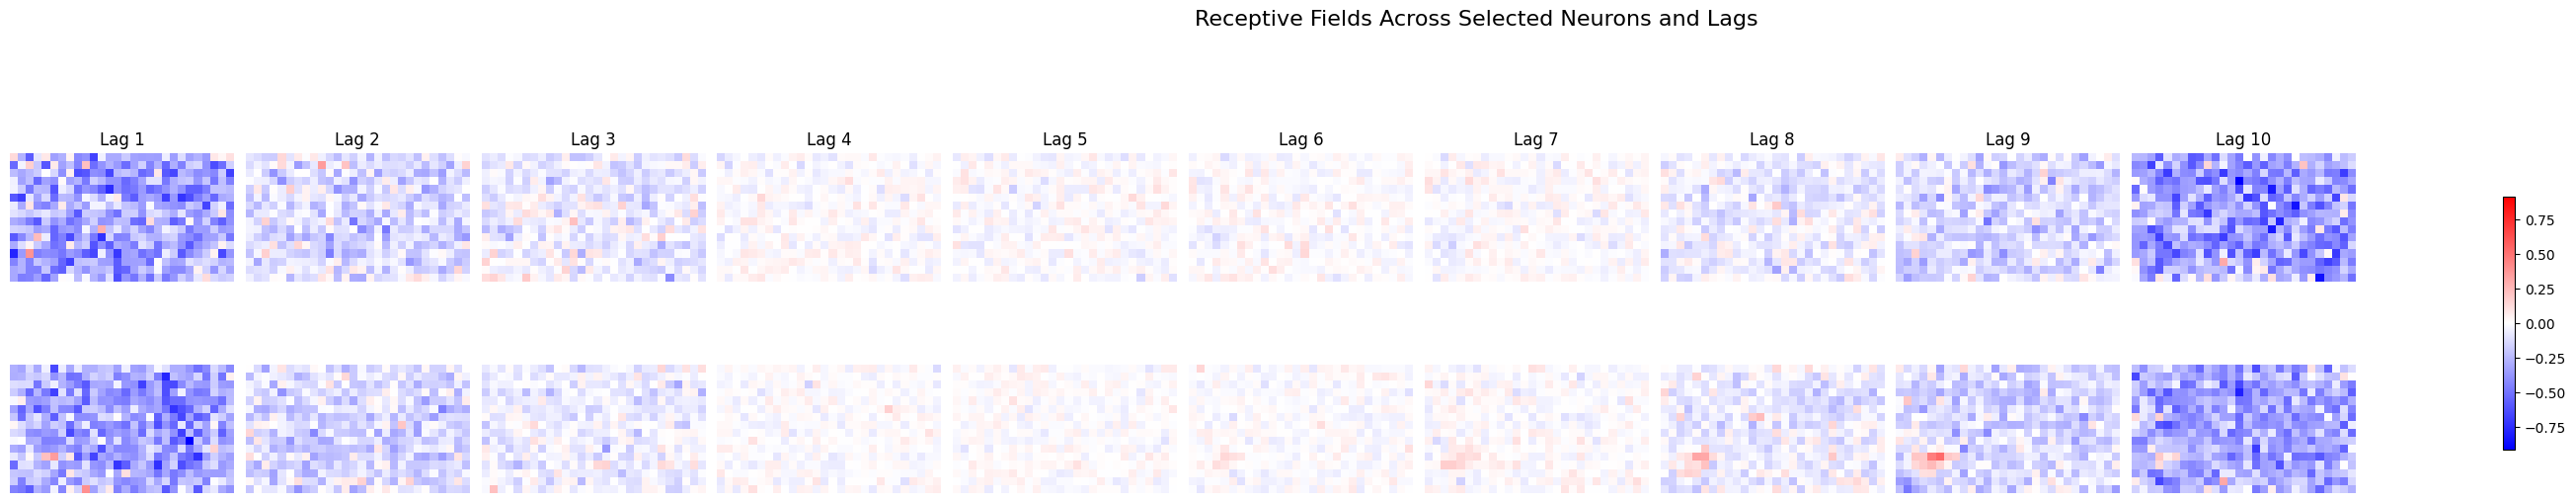

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example inputs:
# receptive_fields: shape (len(selected_neuron_ids), num_pixels * n_lags)
# selected_neuron_ids: list of neuron indices (e.g., [2, 5, 7])
# stim_h, stim_w: height and width of stimulus frames
# n_lags: number of temporal lags

num_neurons_to_plot = len(selected_neuron_ids)

fig, axes = plt.subplots(
    num_neurons_to_plot, n_lags, figsize=(3 * n_lags, 3 * num_neurons_to_plot)
)

# Handle case if only one neuron or one lag (makes axes 1D)
if num_neurons_to_plot == 1:
    axes = np.expand_dims(axes, 0)
if n_lags == 1:
    axes = np.expand_dims(axes, 1)

# Plot each neuron's receptive field
for i, neuron_id in enumerate(selected_neuron_ids):
    rf = receptive_fields[i].reshape(n_lags, stim_h, stim_w)
    vlim = np.max(np.abs(rf))  # symmetric color scale per neuron

    for lag in range(n_lags):
        ax = axes[i, lag]
        im = ax.imshow(rf[lag], cmap="bwr", vmin=-vlim, vmax=vlim)
        ax.set_title(f"Lag {lag+1}" if i == 0 else "")
        ax.axis("off")

    axes[i, 0].set_ylabel(f"Neuron {neuron_id}", fontsize=12)

fig.suptitle("Receptive Fields Across Selected Neurons and Lags", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
plt.show()

In [ ]:
from rfest import splineLNP, build_design_matrix


w_est_spline_coeffs = []
selected_neurons = range(binned_spikes.shape[0])
selected_neurons = [32, 60]
# Select all neurons for fitting
for neuron_idx in selected_neurons:
    neuron_to_fit = neuron_idx
    print(f"binned_spikes.shape: {binned_spikes.shape}")
    neuron_binned_spikes = binned_spikes[neuron_to_fit, :]
    flattened_stim_for_rfest = flattened_on_stimuli.copy()
    print(f"flattened_stim_for_rfest.shape: {flattened_stim_for_rfest.shape}")
    num_lags = 10  # Number of lags to consider for the GLM
    dims = (num_lags, stim_h, stim_w)
    print(f"dims: {dims}")
    df = (8, 8, 12)  # (time, height, width)

    X_design = build_design_matrix(flattened_stim_for_rfest.T, nlag=num_lags)
    # Remove the first num_lags-1 entries from the binned spikes to match the response length
    y_response = np.array(neuron_binned_spikes)
    y_response = y_response.astype(np.float64)

    print(f"X_design.shape: {X_design.shape}")

    print(f"X_design.shape: {X_design.shape}")
    print(f"y_response.shape: {y_response.shape}")
    model = splineLNP(X_design, y_response, dims=dims, df=df)
    print(
        f"Model initialized for Neuron {neuron_to_fit} with dims: {dims} and df: {df}"
    )
    # Fit the model. This performs the optimization.
    print(f"Fitting splineLNP model for Neuron {neuron_to_fit}...")
    model.fit(beta=0.01, num_iters=200, verbose=10)

    # The estimated receptive field is stored in model.w_opt
    w_est_spline = model.w_opt
    w_est_spline_coeffs.append(w_est_spline)
    print(f"\n Neuron {neuron_to_fit} Fitting complete!")
w_est_spline_coeffs = np.array(w_est_spline_coeffs, dtype=np.float64)

binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 32 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 32...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            5.622        46184.031       
10           6.255        36586.811       
20           6.791        29123.155       
30           7.378        23552.824       
40           7.938        19502.081       
50           8.491        16590.601       
60           9.033        14502.835       
70           9.555        13004.962       
80           10.107       11934.136       
90           10.649       11180.329       
100          11.199       10669.289       
110          11.730       10348.108       
120          12.258       10172.633       
130          12.798       10097.980       
140          13.312   

# Statistical Testing and Spatial Analysis

In [ ]:
use_cached_data = True

In [ ]:
# import glob
# import os
# import numpy as np
# import pandas as pd
# import utils
# import utils as U
# import  importlib

# importlib.reload(utils)
# importlib.reload(U)


# if use_cached_data:
#     try:
#         namespace = "aakarsh"

#         background_dir = f'data/{namespace}/receptive_fields_spline/'
#         list_of_background_files = glob.glob(os.path.join(background_dir, '*.npz'))
#         list_of_background_files = [f for f in list_of_background_files if 'w_est_spline_coeffs' in f]
#         print(f"Found files in '{background_dir}': {list_of_background_files}")

#         if not list_of_background_files:
#             raise FileNotFoundError(f"No background data files found in '{background_dir}'")

#         print(f"Found {len(list_of_background_files)} background data files in '{background_dir}'")
#         latest_coefficients_file = max(list_of_background_files, key=os.path.getctime)
#         print(f"Loading latest background data from: {latest_coefficients_file}")
#         loaded_data = np.load(latest_coefficients_file, allow_pickle=True)
#         w_est_spline_coeffs = loaded_data['w_est_spline_coeffs']
#         dims = loaded_data['dims']
#         num_lags, stim_h, stim_w = dims
#             # Load the original raw data to get ROI masks and max projection
#         data = U.load_data() # Assuming the load_data function is in utils.py or defined
#         roi_masks = data['roi_masks']
#         max_projection_image = data['max_projection']

#         print(f"w_est_spline_coeffs loaded with shape: {w_est_spline_coeffs.shape if hasattr(w_est_spline_coeffs, 'shape') else 'N/A'}")
#         print(f"Loaded data keys: {loaded_data.keys()}")
#     except Exception as e:
#         print(f"Error loading background data: {e}")
#         raise

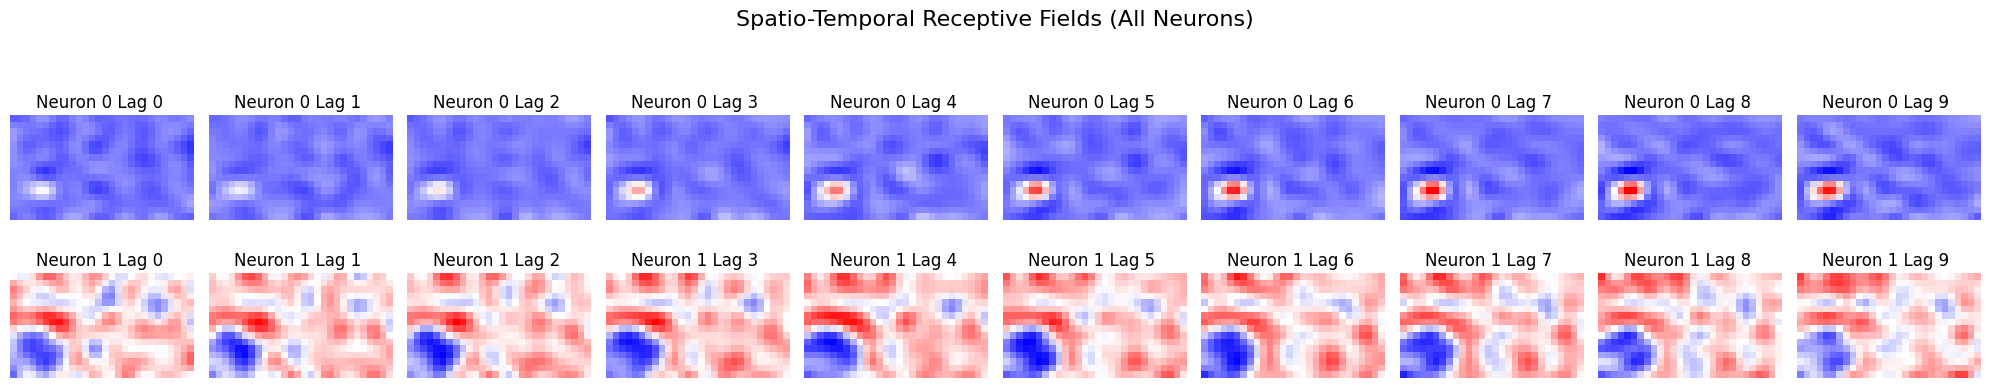

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## 1. Get the dimensions for the plot grid
num_neurons = w_est_spline_coeffs.shape[0]
num_lags, stim_h, stim_w = dims
selected_neurons = range(num_neurons)

# 2. Create a single figure with a grid of subplots
# The grid will have 'num_neurons' rows and 'num_lags' columns.
fig, axes = plt.subplots(
    num_neurons,
    num_lags,
    figsize=(num_lags * 2, num_neurons * 2.2),
    squeeze=False,  # Always return a 2D array for axes
)

fig.suptitle("Spatio-Temporal Receptive Fields (All Neurons)", fontsize=16)

# 3. Loop through each neuron and its corresponding row of axes
for neuron_idx, w_flat in enumerate(w_est_spline_coeffs):
    neuron_id = selected_neurons[neuron_idx]

    # Reshape the flattened weights to (time, height, width)
    strf = w_flat.reshape(dims)

    # Normalize color scale per-neuron for fair comparison across its own lags
    vmin, vmax = strf.min(), strf.max()

    # Set the y-label for the row to identify the neuron
    axes[neuron_idx, 0].set_ylabel(
        f"Neuron {neuron_id}",
        rotation=0,
        size="large",
        labelpad=40,  # Move label to the left
        ha="right",
        va="center",
    )

    # Loop through each time lag and its column
    for lag_idx in range(num_lags):
        ax = axes[neuron_idx, lag_idx]

        # Plot the spatial receptive field at this lag
        ax.imshow(strf[lag_idx], cmap="bwr", vmin=vmin, vmax=vmax)
        ax.axis("off")  # Hide axis ticks and borders

        # --- CHANGE ---
        # Set a title for every subplot to show its corresponding lag.
        # The 'if' condition that restricted this to the first row is removed.
        ax.set_title(f"Neuron {neuron_id} Lag {lag_idx} ")

# 4. Adjust layout and display the single plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to make space for suptitle
plt.show()

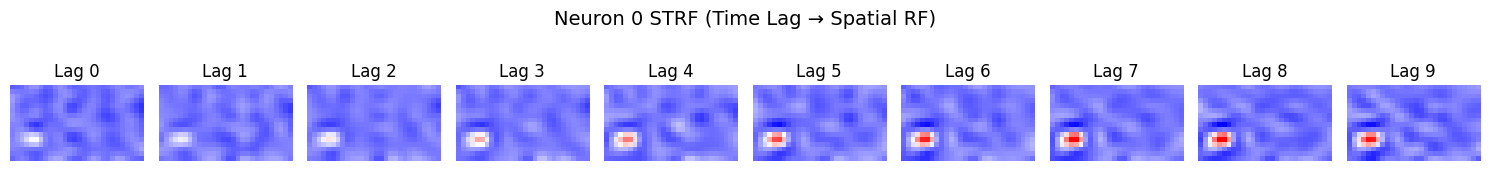

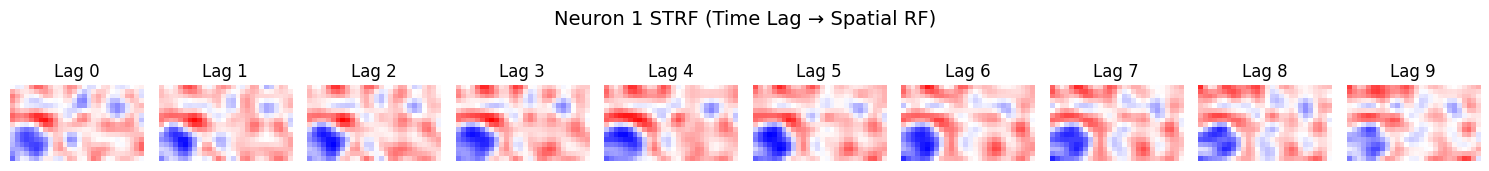

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Reuse dims and selected_neurons
num_lags, stim_h, stim_w = dims
selected_neurons = range(
    w_est_spline_coeffs.shape[0]
)  # Assuming all neurons are selected
for idx, w_flat in enumerate(w_est_spline_coeffs):
    neuron_idx = selected_neurons[idx]

    # Reshape to (time lags, height, width)
    strf = w_flat.reshape(dims)

    # Plot all lags
    fig, axes = plt.subplots(1, num_lags, figsize=(num_lags * 1.5, 2))
    fig.suptitle(f"Neuron {neuron_idx} STRF (Time Lag → Spatial RF)", fontsize=14)

    # Normalize color scale across all lags for fair comparison
    vmin, vmax = strf.min(), strf.max()
    for t in range(num_lags):
        ax = axes[t]
        ax.imshow(strf[t], cmap="bwr", vmin=vmin, vmax=vmax)
        ax.set_title(f"Lag {t}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

### Localized Receptive Fields

In [ ]:
import utils

importlib.reload(utils)
from scipy.linalg import svd


def extract_spatial_rf(w_est_spline_coeffs, dims, selected_neurons=None):
    """
    Extract spatial receptive fields from spline coefficients.

    Args:
        w_est_spline_coeffs: Coefficients of the spline fit.
        dims: Dimensions of the receptive field (num_lags, height, width).
        selected_neurons: List of neuron indices to visualize.

    Returns:
        List of spatial receptive fields for each selected neuron.
    """
    if selected_neurons is None:
        selected_neurons = range(w_est_spline_coeffs.shape[0])
    spatial_rf_list = []
    for neuron_idx in selected_neurons:
        neuron_west_spline = w_est_spline_coeffs[neuron_idx]
        # Reshape the flattened w_est back into its spatio-temporal form
        strf_spline = neuron_west_spline.reshape(dims)  # (20, 16, 28)

        num_pixels = stim_h * stim_w
        strf_for_vis = strf_spline.transpose(1, 2, 0).reshape(num_pixels, num_lags)

        # Perform SVD to get the separated components
        w_centered = strf_for_vis - strf_for_vis.mean(axis=1, keepdims=True)
        U, _, Vt = svd(w_centered, full_matrices=False)

        spatial_rf = U[:, 0].reshape(stim_h, stim_w)
        temporal_rf = Vt[0, :]

        # Sign correction for consistent plotting
        if np.abs(np.min(spatial_rf)) > np.abs(np.max(spatial_rf)):
            spatial_rf *= -1
            temporal_rf *= -1

        spatial_rf_list.append(spatial_rf)

    return np.array(spatial_rf_list)


spatial_rfs = extract_spatial_rf(w_est_spline_coeffs, dims)
gaussian_fits_statistics_df = utils.quantify_all_rfs(spatial_rfs)

AttributeError: module 'utils' has no attribute 'quantify_all_rfs'

In [ ]:
gaussian_fits_statistics_df

neuron_id     r_squared   rf_size  amplitude  rf_center_x  rf_center_y
0           32  7.980294e-01  1.254756   0.409102     4.104507    10.960805
1          112  7.762630e-01  1.275289   0.396093     5.858431    10.805198
2          120  7.630063e-01  1.340931   0.373918     6.141740    10.673456
3           87  7.436450e-01  1.327739   0.373745     3.712810    11.530277
4          182  7.212877e-01  1.159580   0.416098     5.578175    10.829691
..         ...           ...       ...        ...          ...          ...
184         94  0.000000e+00       NaN   0.000000          NaN          NaN
185         70 -2.220446e-16  0.047945   0.048159    27.614599     3.312984
186        157 -2.220446e-16  7.559021   0.043828   -43.471909   -20.006703
187        106 -2.220446e-16  2.309888   0.010537    42.738200     6.513155
188         18 -2.220446e-16  3.743346  -0.010665    42.203671    15.792450

[189 rows x 6 columns]

### Distribution of Gaussian Fits of Receptive Fieldss

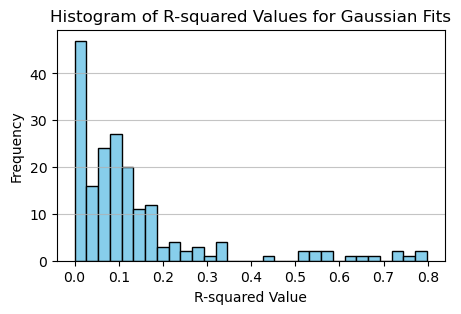

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of R-squared values
plt.figure(figsize=(5, 3))
plt.hist(gaussian_fits_statistics_df['r_squared'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of R-squared Values for Gaussian Fits')
plt.xlabel('R-squared Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Filter neurons with R-squared > 0.5


In [ ]:
high_r_squared_neurons = gaussian_fits_statistics_df[gaussian_fits_statistics_df['r_squared'] > 0.5]

In [ ]:
high_r_squared_neurons

neuron_id  r_squared   rf_size  amplitude  rf_center_x  rf_center_y
0          32   0.798029  1.254756   0.409102     4.104507    10.960805
1         112   0.776263  1.275289   0.396093     5.858431    10.805198
2         120   0.763006  1.340931   0.373918     6.141740    10.673456
3          87   0.743645  1.327739   0.373745     3.712810    11.530277
4         182   0.721288  1.159580   0.416098     5.578175    10.829691
5         179   0.668516  3.020953   0.166681     6.322223    12.618535
6          43   0.643597  1.446244   0.310654     4.676575    12.050324
7          50   0.623774  1.100576   0.411854     4.590362    10.963093
8         111   0.568624  1.243492   0.348849     4.440787    10.892501
9          24   0.562344  1.123212   0.382697     5.546003    10.803204
10         28   0.551649  1.456499   0.296643     4.421178     8.695520
11         77   0.545933  1.340116   0.313035     5.497169    10.604820
12        107   0.531556  1.541113   0.276195     5.009923    11.600878
13        114   0.520306  2.938078   0.154920     2.842087    11.271399

#### Visualize Simple Receptive Fields

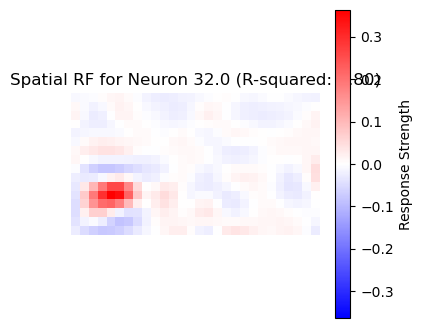

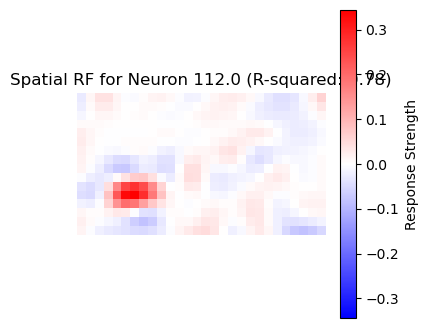

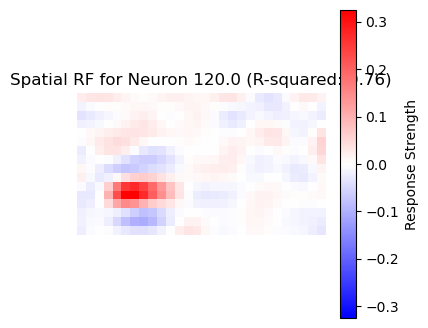

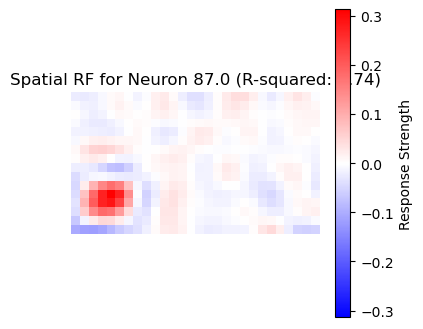

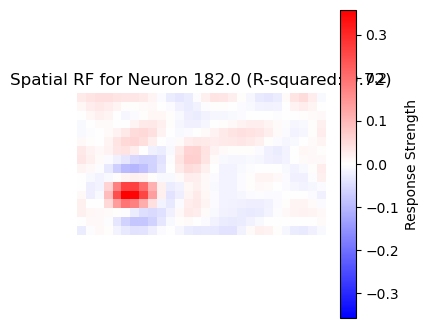

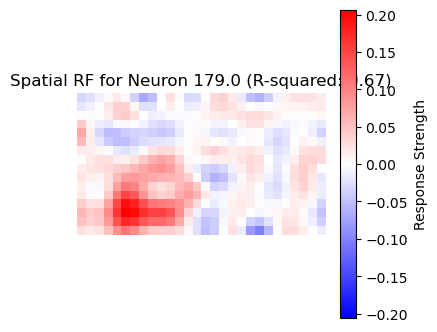

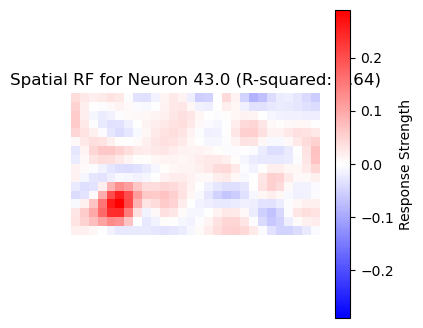

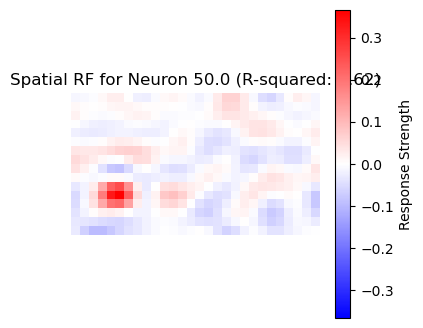

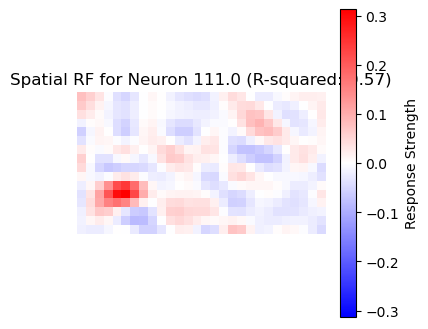

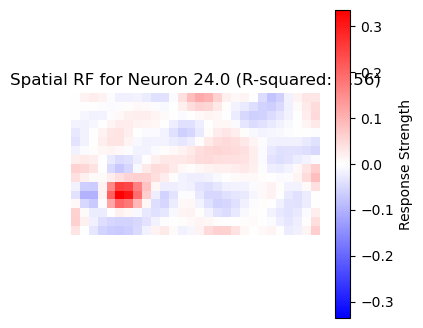

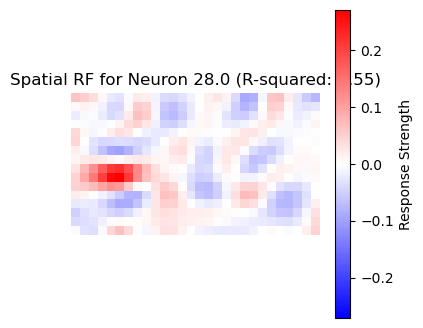

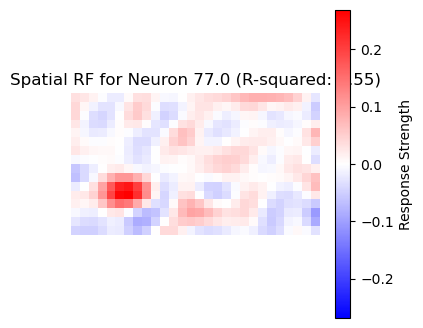

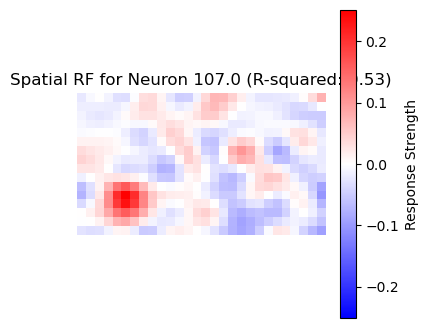

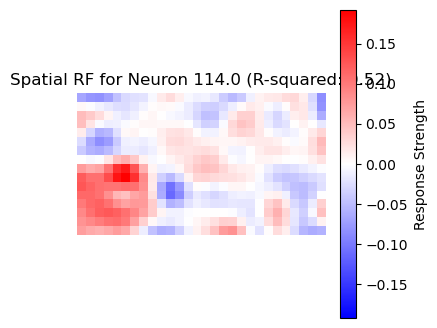

In [ ]:
spatial_rfs = extract_spatial_rf(w_est_spline_coeffs, dims, selected_neurons=high_r_squared_neurons['neuron_id'].tolist())
for idx, row in high_r_squared_neurons.iterrows():
    spatial_rf = spatial_rfs[idx]
    plt.figure(figsize=(4, 4))
    plt.imshow(spatial_rf, cmap='bwr', vmin=-np.max(np.abs(spatial_rf)), vmax=np.max(np.abs(spatial_rf)))
    plt.title(f"Spatial RF for Neuron {row['neuron_id']} (R-squared: {row['r_squared']:.2f})")
    plt.colorbar(label='Response Strength')
    plt.axis('off')
    plt.show()

Calculating ROI centroid for neuron 32 (1/14)
Calculating centroids of ROI masks...
ROI centroid calculation complete.
Calculating ROI centroid for neuron 112 (2/14)
Calculating centroids of ROI masks...
ROI centroid calculation complete.
Calculating ROI centroid for neuron 120 (3/14)
Calculating centroids of ROI masks...
ROI centroid calculation complete.
Calculating ROI centroid for neuron 87 (4/14)
Calculating centroids of ROI masks...
ROI centroid calculation complete.
Calculating ROI centroid for neuron 182 (5/14)
Calculating centroids of ROI masks...
ROI centroid calculation complete.
Calculating ROI centroid for neuron 179 (6/14)
Calculating centroids of ROI masks...
ROI centroid calculation complete.
Calculating ROI centroid for neuron 43 (7/14)
Calculating centroids of ROI masks...
ROI centroid calculation complete.
Calculating ROI centroid for neuron 50 (8/14)
Calculating centroids of ROI masks...
ROI centroid calculation complete.
Calculating ROI centroid for neuron 111 (9/1

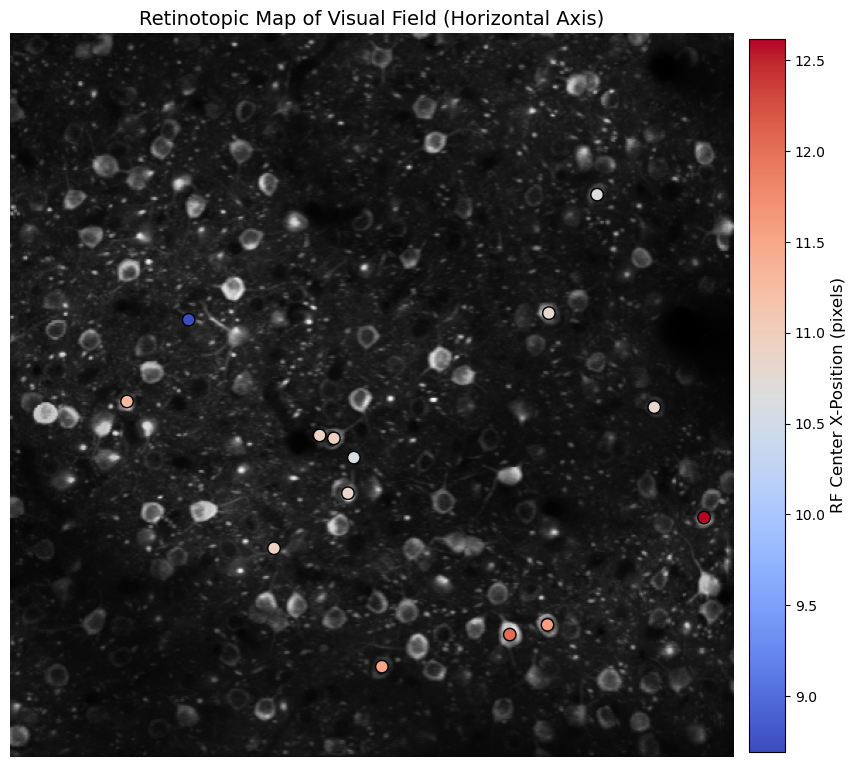

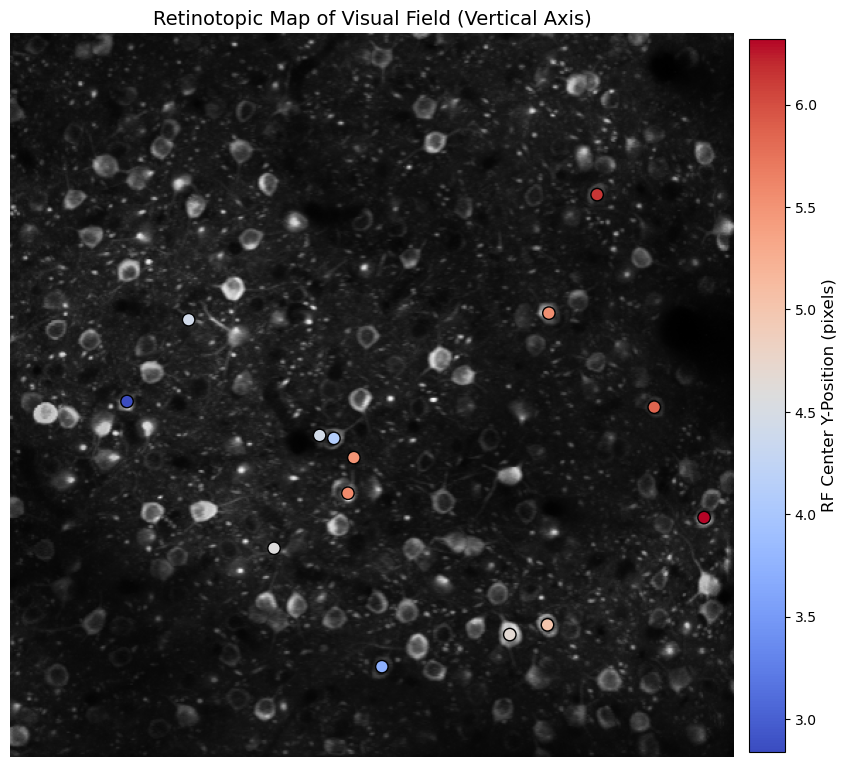

In [ ]:
# Calculate the physical (x, y) coordinates for each neuron from its ROI mask
neuron_idxs = high_r_squared_neurons['neuron_id'].tolist() if 'neuron_id' in high_r_squared_neurons.columns else None
roi_centroids = []
for idx, neuron_idx in enumerate(neuron_idxs):
    print(f"Calculating ROI centroid for neuron {neuron_idx} ({idx+1}/{len(neuron_idxs)})") 
    roi_mask_selection = np.array([roi_masks[neuron_idx]])
    roi_centroids.append(U.calculate_roi_centroids(roi_mask_selection))
roi_centroids = np.array(roi_centroids)
roi_centroids = roi_centroids.reshape(-1, 2)  # Ensure shape is (N, 2) for (x, y) coordinates
print(f"All ROI centroids: {roi_centroids.shape}")

# Calculate the functional (x, y) coordinates for each RF from the spatial maps
rf_centers = np.array(list(zip(high_r_squared_neurons['rf_center_x'].values , high_r_squared_neurons['rf_center_y'].values)))
print(f"RF centers shape: {rf_centers.shape if rf_centers is not None else 'N/A'}")
#U.calculate_rf_centers(all_rfs_spatial)


# --- Step 3: Visualize the Retinotopic Map ---
# This is the key visualization that tests the project's hypothesis.
# We create two plots to map the horizontal (X) and vertical (Y) axes.

print("\nGenerating retinotopic maps...")

# Plot 1: Map of the horizontal (X) axis of the visual field
U.plot_retinotopic_map(
    roi_centroids=roi_centroids,
    rf_centers=rf_centers,
    background_image=max_projection_image,
    axis_to_map='x'
)

# Plot 2: Map of the vertical (Y) axis of the visual field
U.plot_retinotopic_map(
    roi_centroids=roi_centroids,
    rf_centers=rf_centers,
    background_image=max_projection_image,
    axis_to_map='y'
)